In [1]:
import numpy as np
import pandas as pd
import imp
import os
import sys
import tensorflow as tf
import random
from numba import njit
from functools import lru_cache
from IPython.display import Audio, display
from matplotlib import pyplot as plt

tf.random.set_seed(1234)
random.set_seed(1234)

<module 'stops' from 'C:\\Users\\graham\\code_projects\\bus_prediction\\src\\stops.py'>

# notes
* we can actually shuffle the data because we're just trying to predict the next bus.
* it might be worth trying it out with a non constrained input and output. 
* because we can make an embedding for stop and the like, we could instead to a 10 to 10 or so sequence
* it would take it 10, and guess 10. zero pad the left on the input and the right on the output
* could also read the sequence to sequence paper!

In [2]:
url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

url_done = (
    "https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav"
)
url_done = "https://www.myinstants.com/media/sounds/taco-bell-bong-sfx.mp3"
url_done = "https://www.myinstants.com/media/sounds/magic_immune.mp3"


def allDone():
    display(
        Audio(
            url=url_done,
            autoplay=True,
        )
    )

In [3]:
data_dir = os.path.join(os.getcwd(), "..", "data")

In [4]:
direction = 1

In [5]:
def df_pop(df, labels):
    popped = df[labels]
    df = df.drop(columns=labels)
    return df, popped


trips, dates, labels = None, None, None
lstm_dir = os.path.join(data_dir, "trips_for_lstm")
files = [
    f + "_direction_" + str(direction) + ".npy"
    for f in ["non_categories", "categories_per_trip", "categories_per_stop", "labels"]
]

files_cardinality = [
    f + "_direction_" + str(direction) + ".npy"
    for f in ["cardinality_per_stop", "cardinality_per_trip"]
]

cardinality = {}
cardinality_per_stop = []
cardinality_per_trip = []

recompute = False

if recompute:

    pickle_path = os.path.join(data_dir, "mega_pickle")
    df = pd.read_pickle(pickle_path)
    #     df = df.head(100000)

    df = df.drop(columns=["route_number", "time_cat_stop_time", "time_cat_leave_time"])

    df = df.sort_values(["service_date", "train", "trip_number", "stop_time"])
    df = df.reset_index(drop=True)

    df = df[df["direction"] == direction]

    dtypes = df.dtypes
    categories_names = dtypes[dtypes == "category"]
    categories_names = categories_names.index.to_list()
    non_categories_names = dtypes[dtypes != "category"]
    non_categories_names = non_categories_names.index.to_list()

    cat_per_trip = categories_names.copy()

    for category in categories_names:
        df[category] = df[category].cat.codes
        cardinality[category] = len(df[category].unique())

    trips = df.groupby(["service_date", "train", "trip_number"])
    trips = [trip for _, trip in trips]

    random.shuffle(
        trips
    )  # WE CAN DO THIS BECAUSE WE'RE ONLY TRYING TO PREDICT THE NEXT TRIP

    hist = {}
    for trip in trips:
        trip = trip.drop_duplicates("location_id")

        for cat in cat_per_trip:
            if len(trip[cat].unique()) > 1:
                cat_per_trip.remove(cat)

        s = tuple(trip["location_id"].to_list())
        if s in hist:
            hist[s] = hist[s] + 1
        else:
            hist[s] = 1

    cat_per_stop = list(set(categories_names) - set(cat_per_trip))
    assert set(categories_names) == set(cat_per_stop + cat_per_trip)

    for cat in cat_per_trip:
        cardinality_per_trip.append(cardinality[cat])

    for cat in cat_per_stop:
        cardinality_per_stop.append(cardinality[cat])

    sorted_stops = sorted(hist.items(), key=lambda x: x[1], reverse=True)
    most_common_stops = list(sorted_stops[0][0])

    x1 = []
    x2 = []
    x3 = []
    y = []
    for trip in trips:
        trip = trip.drop_duplicates("location_id")
        if trip["location_id"].to_list() == most_common_stops:

            #             trip = trip.drop(
            #                 columns=[
            #                     "service_date",
            #                     "stop_time",
            #                     "leave_time",
            #                     "vehicle_number",
            #                     "location_id",
            #                     "train",
            #                 ]
            #             )

            labels = trip["arrival_deviance"]

            categories_per_trip = trip[cat_per_trip]
            categories_per_trip = categories_per_trip.iloc[0]
            categories_per_stop = trip[cat_per_stop]
            non_categories = trip[non_categories_names]

            non_categories = non_categories.drop(columns=["service_date"])

            # MAYBE AN ISSUE AS WE'RE STACKING PANDAS DATAFRAMES RATHER THAN NP ARRAYS

            x1.append(non_categories)
            x2.append(categories_per_trip)
            x3.append(categories_per_stop)
            y.append(labels)

    non_categories = np.stack(x1)
    categories_per_trip = np.stack(x2)
    categories_per_stop = np.stack(x3)
    labels = np.stack(y)

    arrays = [non_categories, categories_per_trip, categories_per_stop, labels]

    for file_name, array in zip(files, arrays):
        file_path = os.path.join(lstm_dir, file_name)
        np.save(file_path, array)

    cardinality_per_stop = np.array(cardinality_per_stop)
    cardinality_per_trip = np.array(cardinality_per_trip)
    arrays = [cardinality_per_stop, cardinality_per_trip]

    for file_name, array in zip(files_cardinality, arrays):
        file_path = os.path.join(lstm_dir, file_name)
        np.save(file_path, array)

else:
    arrays = []
    for file_name in files:
        file_path = os.path.join(lstm_dir, file_name)
        arrays.append(np.load(file_path))
    non_categories, categories_per_trip, categories_per_stop, labels = arrays

    arrays = []
    for file_name in files_cardinality:
        file_path = os.path.join(lstm_dir, file_name)
        arrays.append(np.load(file_path))
    cardinality_per_stop, cardinality_per_trip = arrays

print(
    non_categories.shape,
    categories_per_trip.shape,
    categories_per_stop.shape,
    labels.shape,
)

datalen = non_categories.shape[0]
num_stops = non_categories.shape[1]
non_category_width = non_categories.shape[2]
category_per_stop_width = categories_per_stop.shape[2]
category_per_trip_width = categories_per_trip.shape[1]

(15168, 85, 18) (15168, 5) (15168, 85, 5) (15168, 85)


In [6]:
in_length = 20
out_length = 10

non_categories_shape = (in_length, non_category_width)
categories_per_stop_shape = (in_length, category_per_stop_width)
categories_per_trip_shape = (category_per_trip_width,)
label_shape = (out_length,)

num_samples = 10
datalen = datalen * num_samples


def data_generator(non_categories, categories_per_stop, categories_per_trip, labels):
    for non_category, category_stop, category_trip, label in zip(
        non_categories, categories_per_stop, categories_per_trip, labels
    ):
        random_list = random.sample(range(21, 70), num_samples)
        for i in random_list:
            non_cat = non_category[i - in_length : i]
            cat_stop = category_stop[i - in_length : i]
            y = label[i : i + out_length]
            #             category_stop[i:] = 0
            yield {
                "non_categories": non_cat,
                "categories_per_stop": cat_stop,
                "categories_per_trip": category_trip,
            }, y


def get_dataset(non_categories, categories_per_stop, categories_per_trip, labels):
    return tf.data.Dataset.from_generator(
        data_generator,
        args=[non_categories, categories_per_stop, categories_per_trip, labels],
        output_signature=(
            {
                "non_categories": tf.TensorSpec(
                    shape=non_categories_shape, dtype=tf.float32
                ),
                "categories_per_stop": tf.TensorSpec(
                    shape=categories_per_stop_shape, dtype=tf.int32
                ),
                "categories_per_trip": tf.TensorSpec(
                    shape=categories_per_trip_shape, dtype=tf.int32
                ),
            },
            tf.TensorSpec(shape=label_shape, dtype=tf.float32),
        ),
    )

In [7]:
batch_size = 32

train = 0.8
val = 0.1
test = 0.1
assert train + val + test == 1

train = int(train * datalen)
val = int(val * datalen)
test = int(test * datalen)

print(train, val, test)

dataset = get_dataset(non_categories, categories_per_stop, categories_per_trip, labels)

train_dataset = dataset.take(train).shuffle(1000).batch(batch_size)
val_dataset = dataset.skip(train).take(val).batch(batch_size)
test_dataset = dataset.skip(train + val).batch(batch_size)

121344 15168 15168


In [8]:
drop_rate = 0.2
embed_dim = 64

non_categories_input = tf.keras.Input(shape=non_categories_shape, name="non_categories")
categories_per_stop_input = tf.keras.Input(
    shape=categories_per_stop_shape, name="categories_per_stop"
)
categories_per_trip_input = tf.keras.Input(
    shape=categories_per_trip_shape, name="categories_per_trip"
)

non_categories = non_categories_input
categories_per_stop = categories_per_stop_input
categories_per_trip = categories_per_trip_input

cat_list = tf.unstack(categories_per_stop, axis=2)
embed_out_stop = []
for cat, cardinality_per in zip(cat_list, cardinality_per_stop):
    embed_out_stop.append(tf.keras.layers.Embedding(cardinality_per, embed_dim)(cat))

non_categories = tf.keras.layers.BatchNormalization()(non_categories)

per_stop = tf.keras.layers.Concatenate(axis=2)([non_categories, *embed_out_stop])
per_stop = tf.keras.layers.LSTM(128, return_sequences=True)(per_stop)
per_stop = tf.keras.layers.Flatten()(per_stop)
per_stop = tf.keras.layers.BatchNormalization()(per_stop)

cat_list = tf.unstack(categories_per_trip, axis=1)
embed_out_trip = []
for cat, cardinality_per in zip(cat_list, cardinality_per_trip):
    embed_out_trip.append(tf.keras.layers.Embedding(cardinality_per, embed_dim)(cat))


pred = tf.keras.layers.concatenate([per_stop, *embed_out_trip])
pred = tf.keras.layers.BatchNormalization()(pred)
pred = tf.keras.layers.Dropout(drop_rate)(pred)
pred = tf.keras.layers.Dense(1000, activation="relu")(pred)
pred = tf.keras.layers.Dropout(drop_rate)(pred)
pred = tf.keras.layers.Dense(500, activation="relu")(pred)
pred = tf.keras.layers.Dropout(drop_rate)(pred)
pred = tf.keras.layers.Dense(100, activation="relu")(pred)
pred = tf.keras.layers.Dense(out_length, name="output")(pred)

model = tf.keras.Model(
    inputs=[non_categories_input, categories_per_stop_input, categories_per_trip_input],
    outputs=[pred],
)

total parameters: 3,774,186


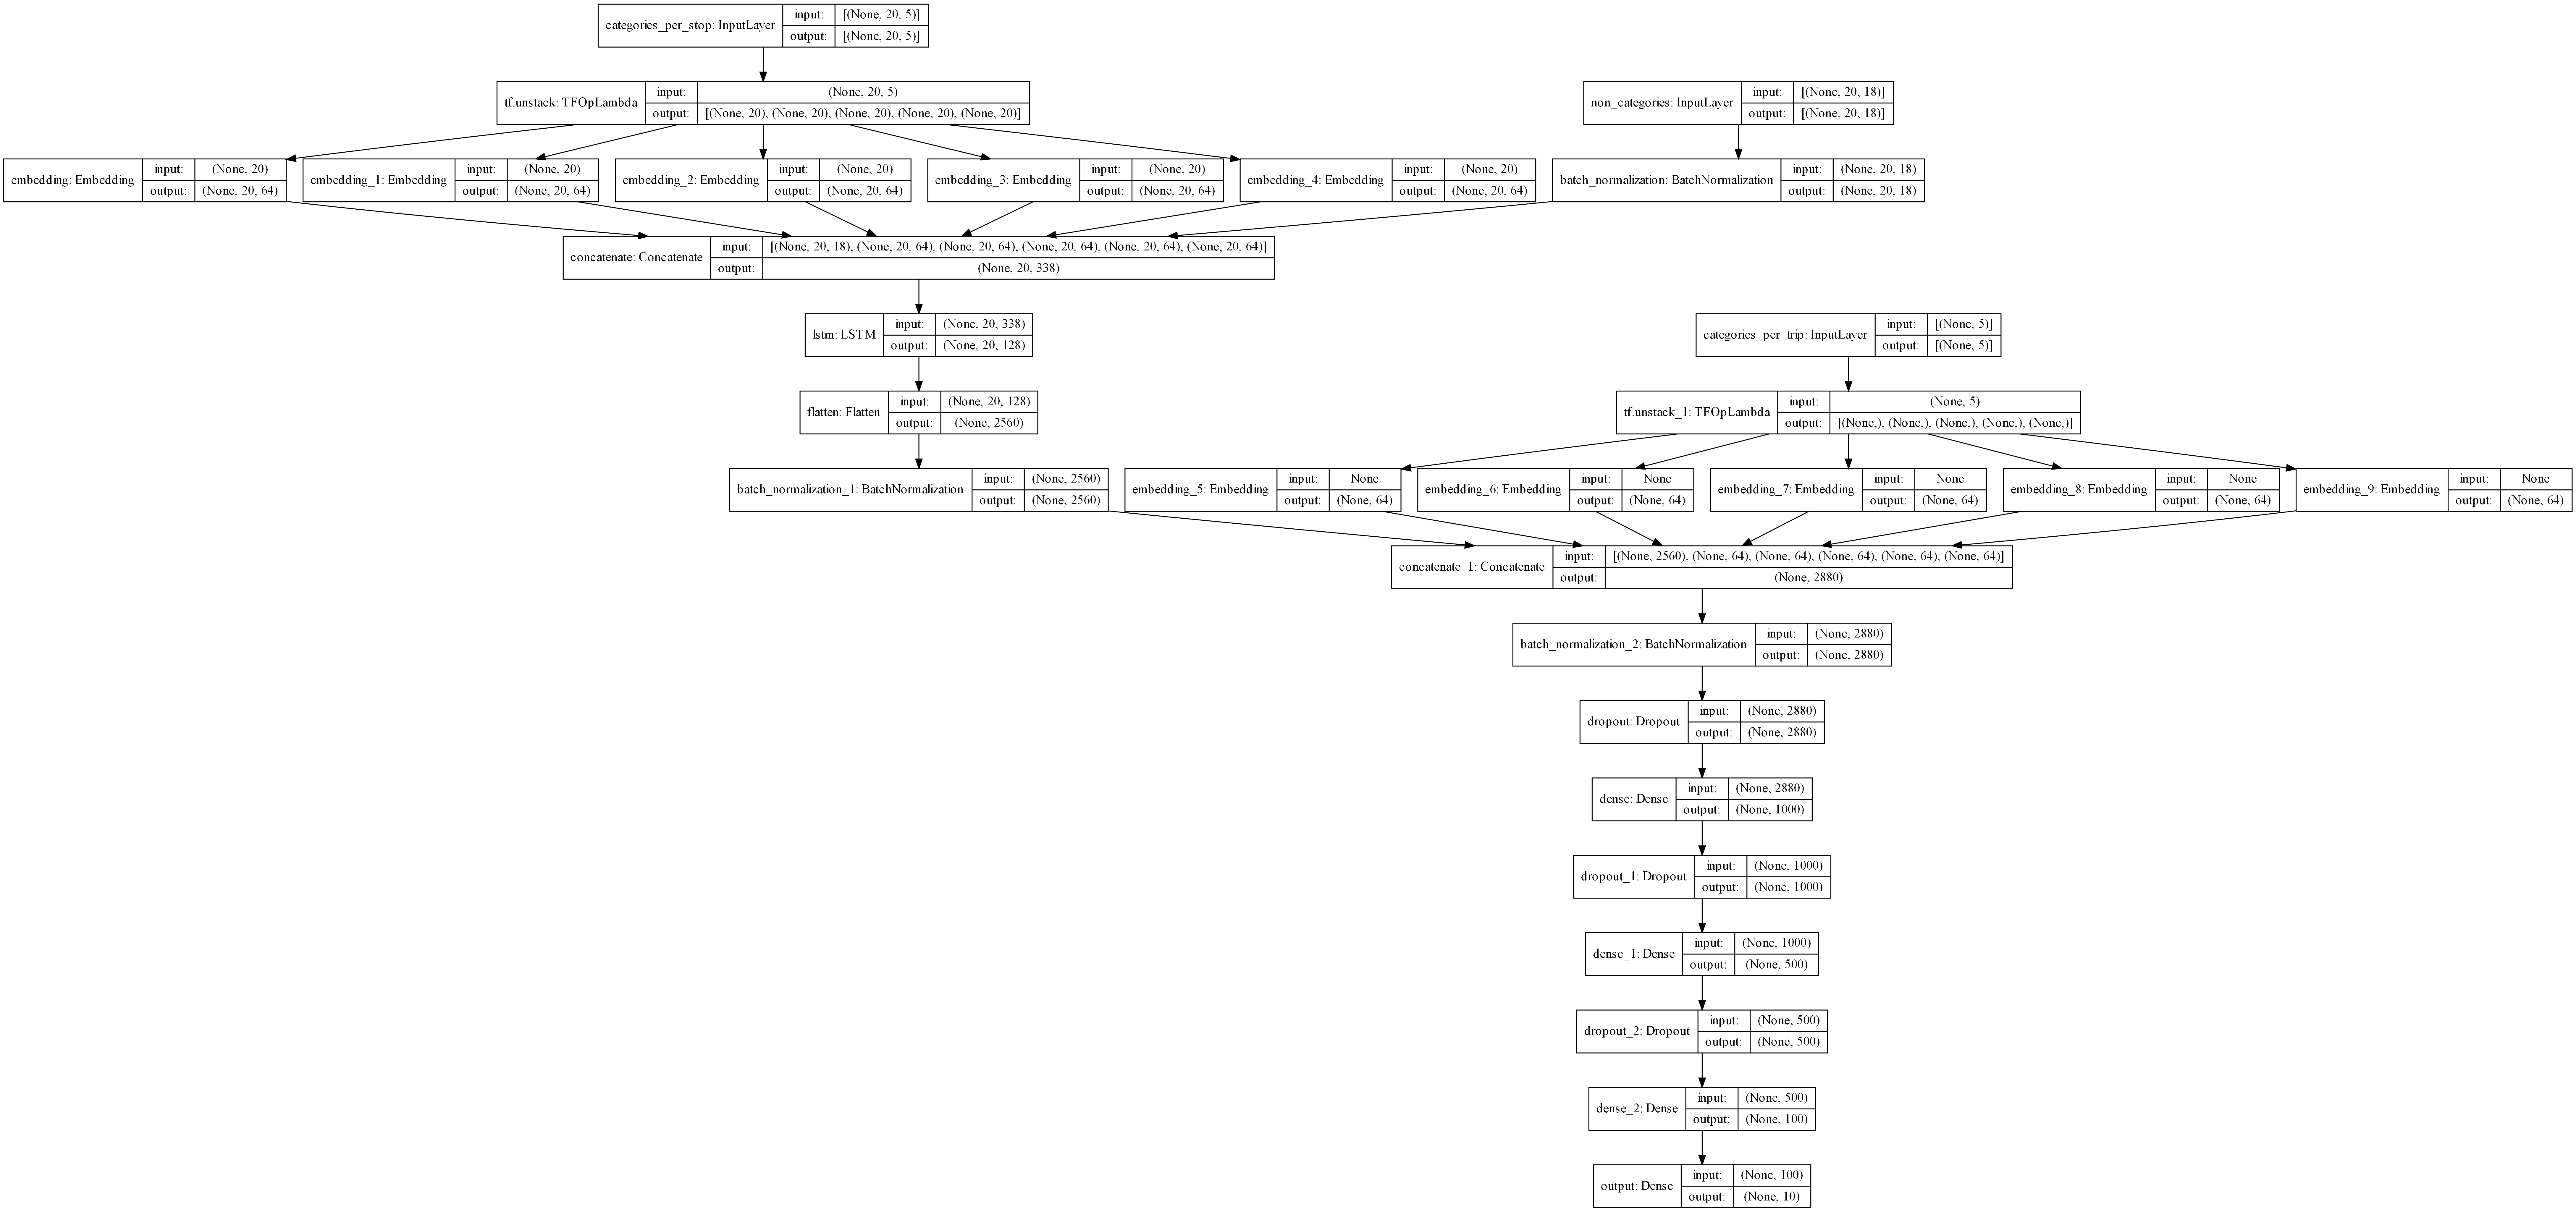

In [9]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    metrics=["MAE"],
)
print("total parameters: {:,}".format(model.count_params()))
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, dpi=227)

In [10]:
monitor_param = "val_loss"

nan_terminate = tf.keras.callbacks.TerminateOnNaN()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_param, patience=10  # , restore_best_weights=True
)

model_dir = os.path.join(data_dir, "model")
checkpoint_filepath = os.path.join(model_dir, "checkpoint")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor_param,
    mode="min",
    save_best_only=True,
)

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, nan_terminate],
)

Num GPUs Available:  1
Epoch 1/100
3792/3792 [==============================] - 101s 26ms/step - loss: 6667.5181 - MAE: 50.4056 - val_loss: 4428.9546 - val_MAE: 43.2513
Epoch 2/100
3792/3792 [==============================] - 98s 26ms/step - loss: 5333.4482 - MAE: 46.9699 - val_loss: 4138.8672 - val_MAE: 42.8071
Epoch 3/100
3792/3792 [==============================] - 98s 26ms/step - loss: 5025.1143 - MAE: 45.3021 - val_loss: 6221.0063 - val_MAE: 45.9340
Epoch 4/100
3792/3792 [==============================] - 97s 25ms/step - loss: 4718.4175 - MAE: 44.5701 - val_loss: 69135.3984 - val_MAE: 52.2386
Epoch 5/100
3792/3792 [==============================] - 96s 25ms/step - loss: 4546.1323 - MAE: 44.0620 - val_loss: 73997.7500 - val_MAE: 49.7990
Epoch 6/100
3792/3792 [==============================] - 96s 25ms/step - loss: 4161.5366 - MAE: 43.2699 - val_loss: 61982.2305 - val_MAE: 51.2670
Epoch 7/100
3792/3792 [==============================] - 97s 25ms/step - loss: 4050.2834 - MAE: 43.0007

In [12]:
model.load_weights(checkpoint_filepath)

In [13]:
model.evaluate(test_dataset)

474/474 [==============================] - 20s 8ms/step - loss: 3944.4866 - MAE: 41.4785


[3944.486572265625, 41.47849655151367]

In [14]:
preds = model.predict(test_dataset)

In [15]:
print(preds.shape)

(15168, 10)


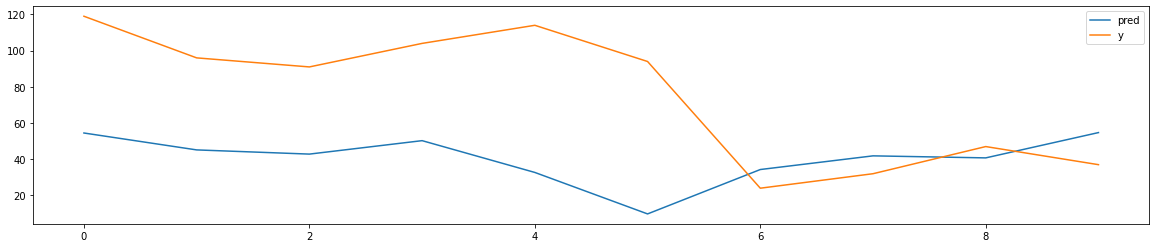

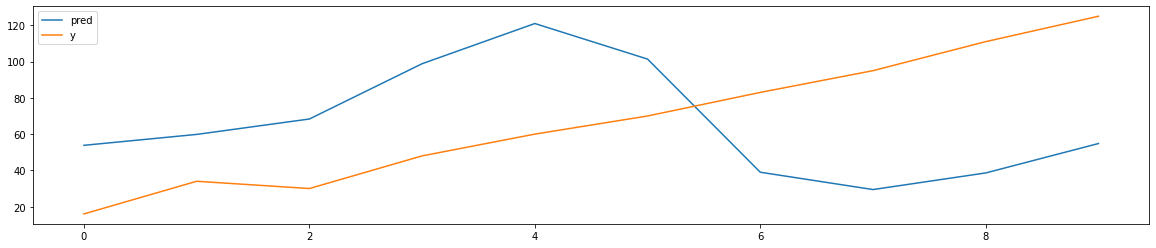

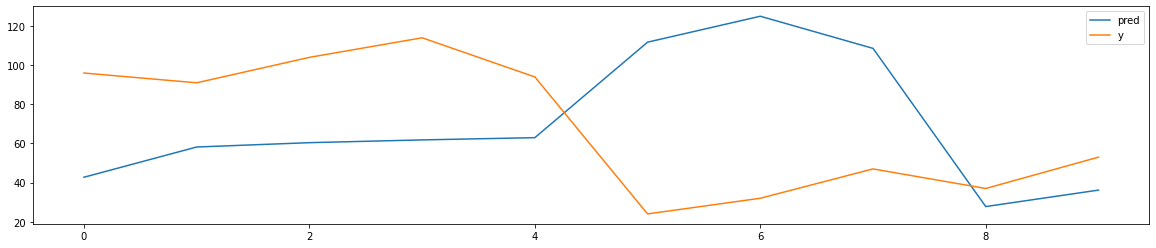

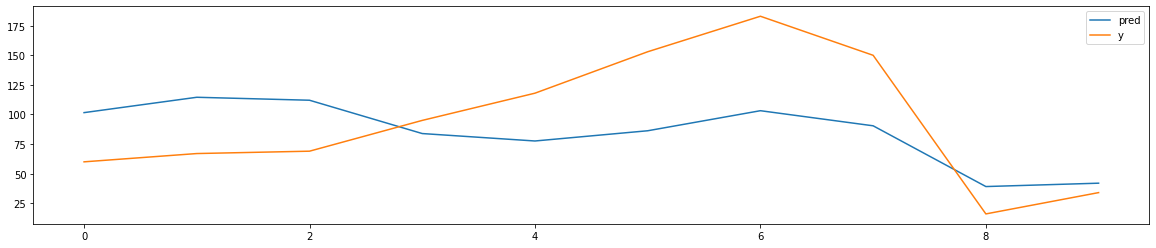

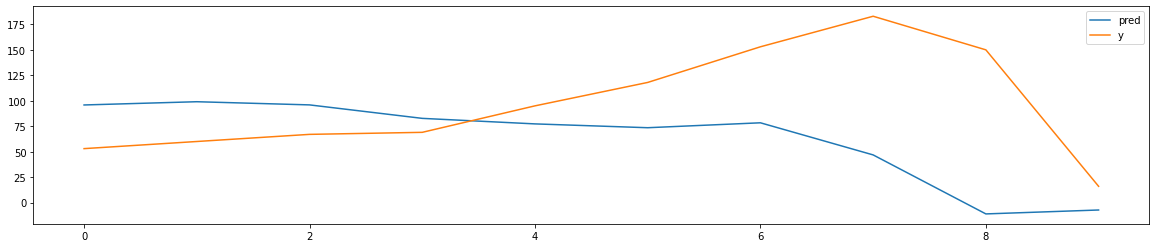

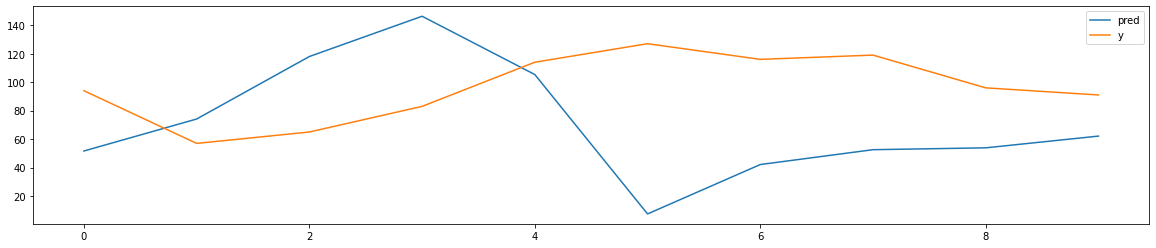

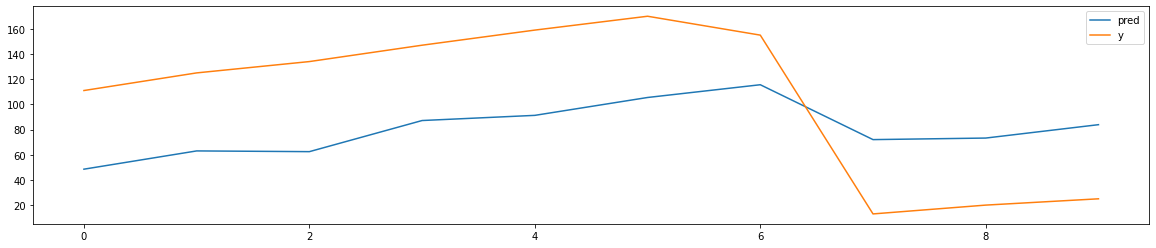

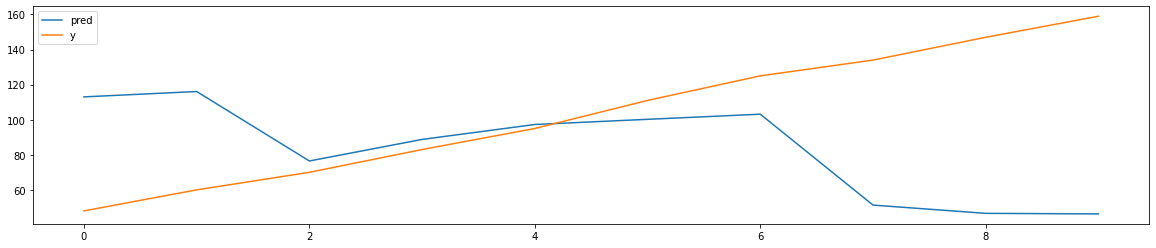

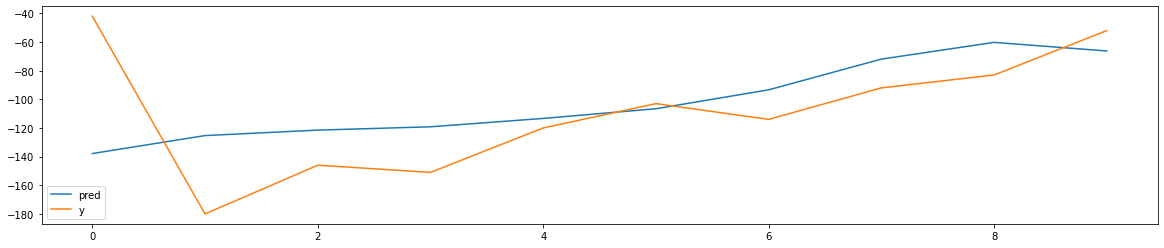

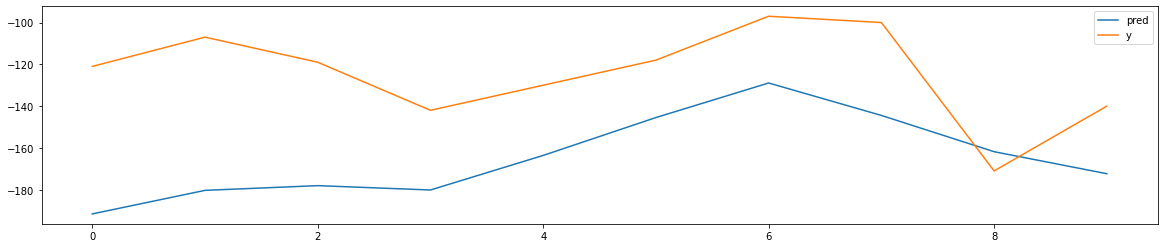

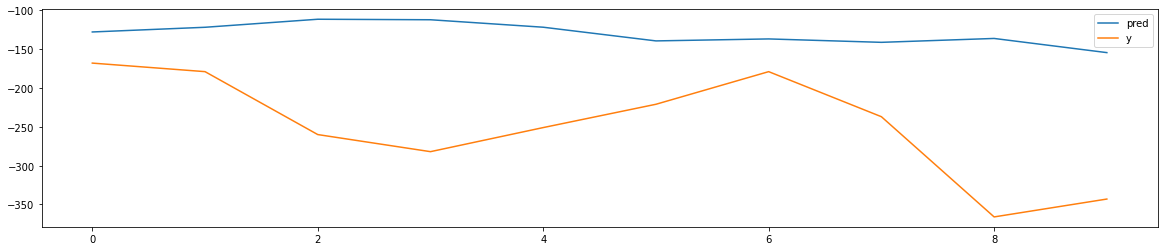

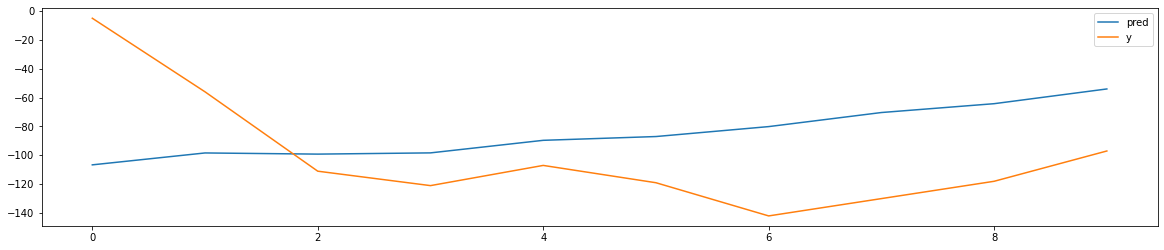

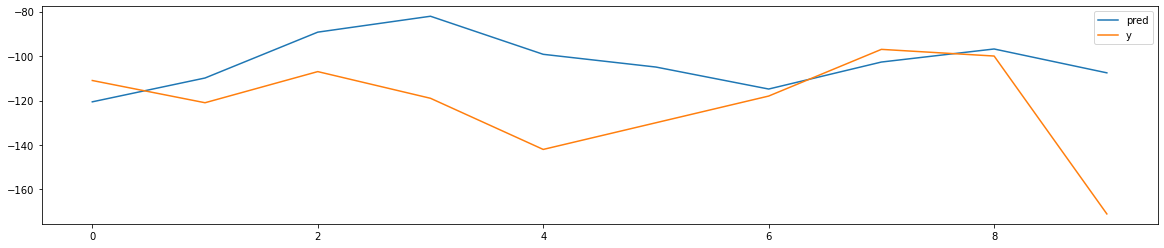

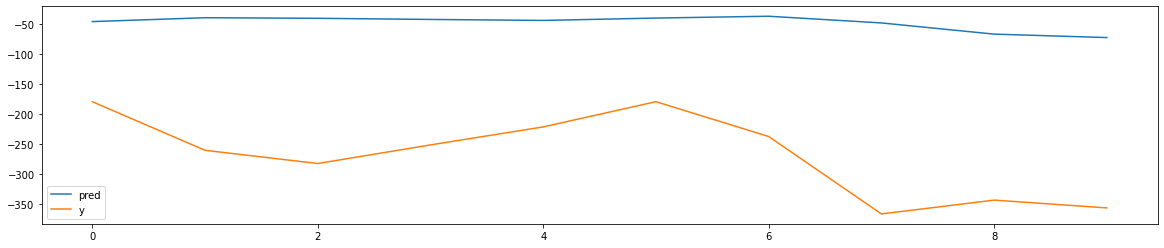

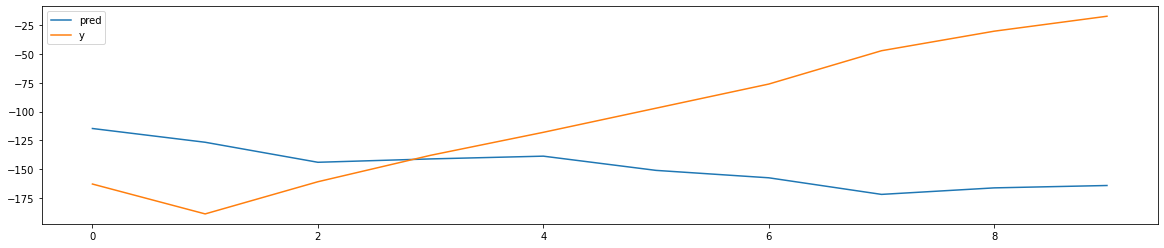

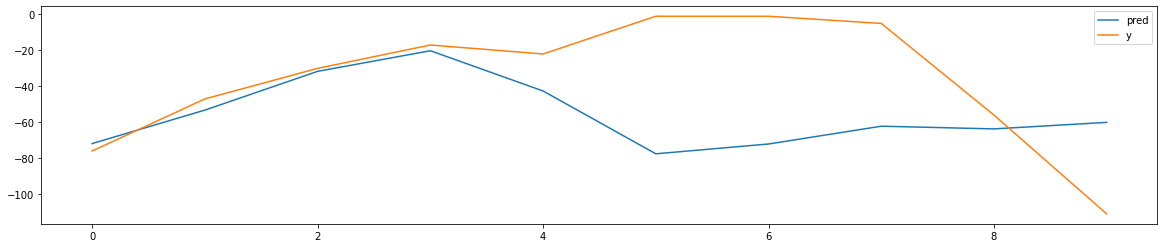

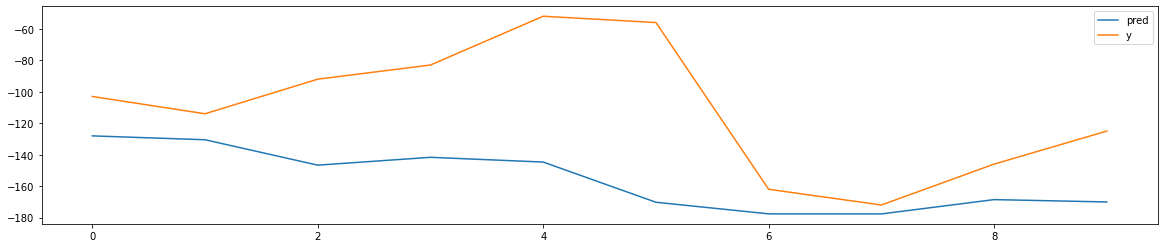

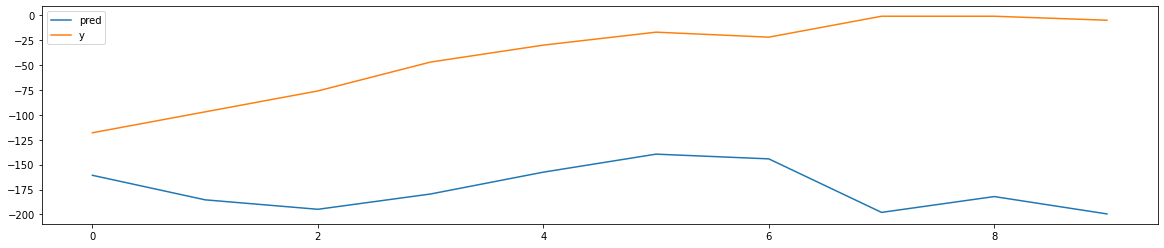

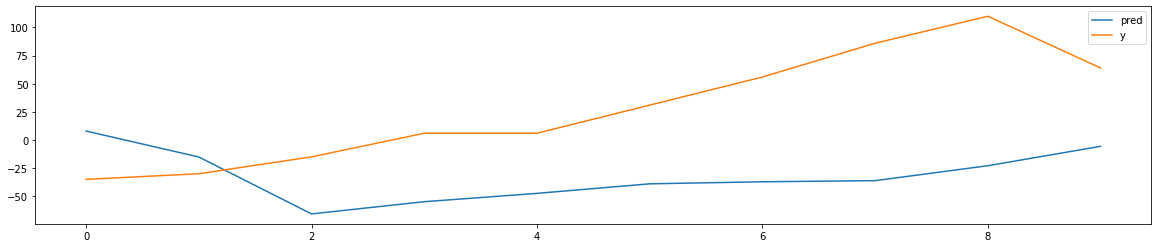

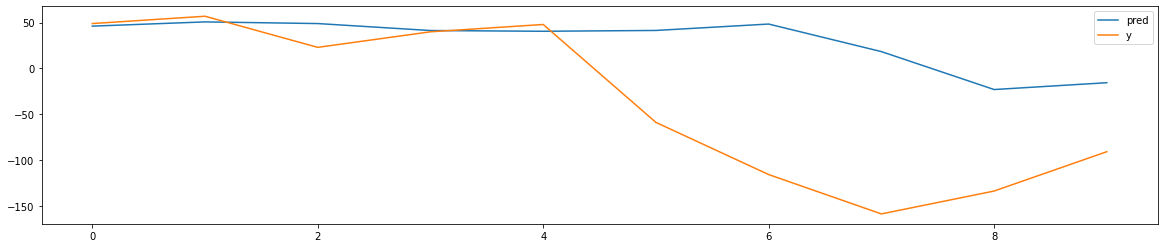

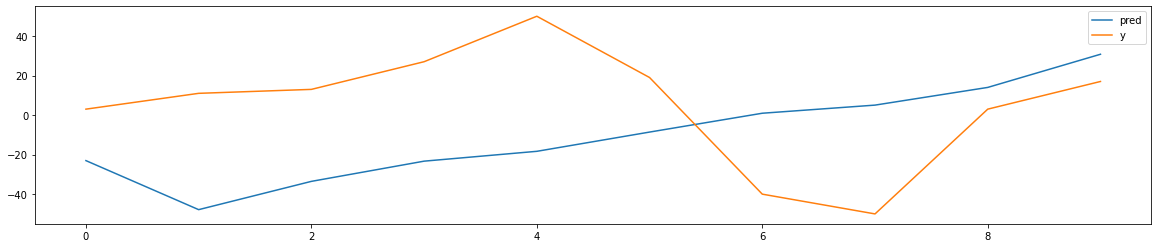

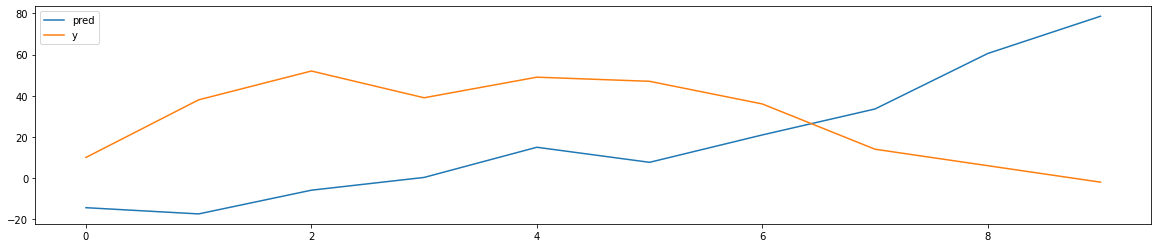

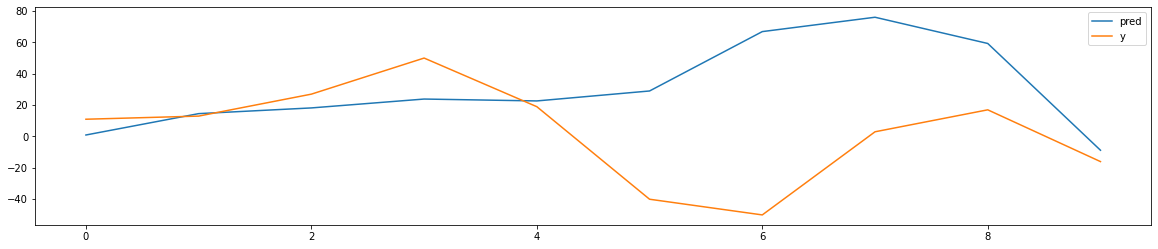

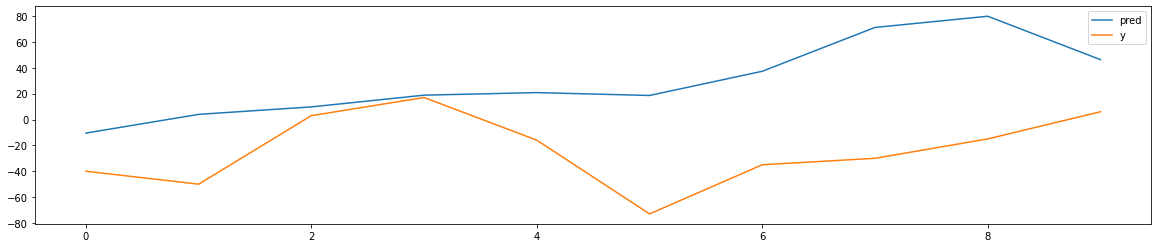

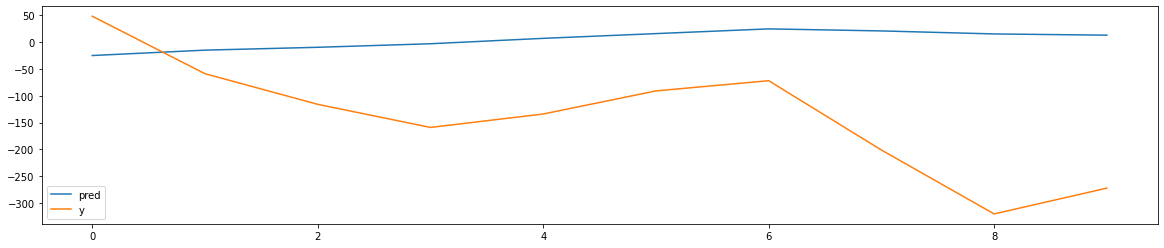

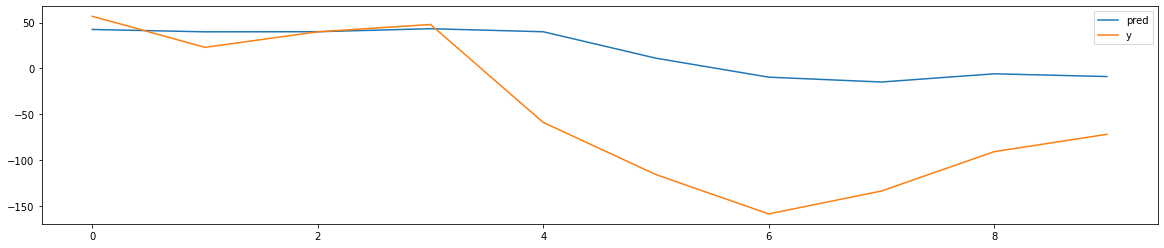

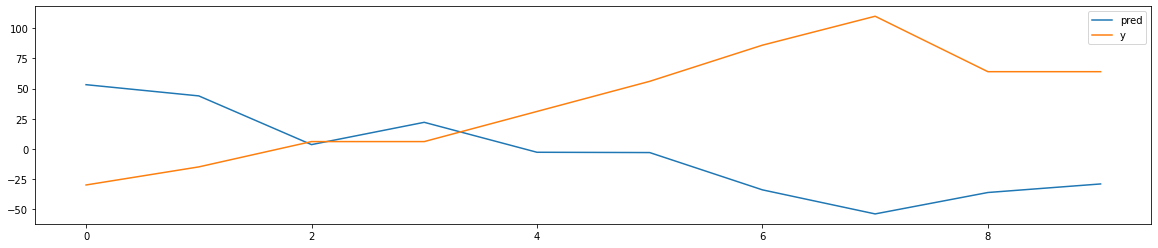

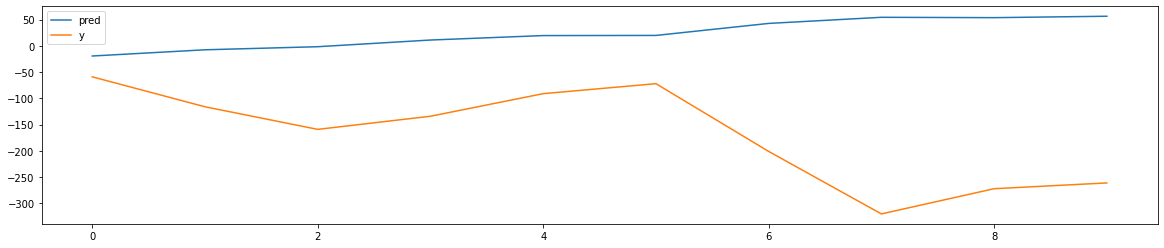

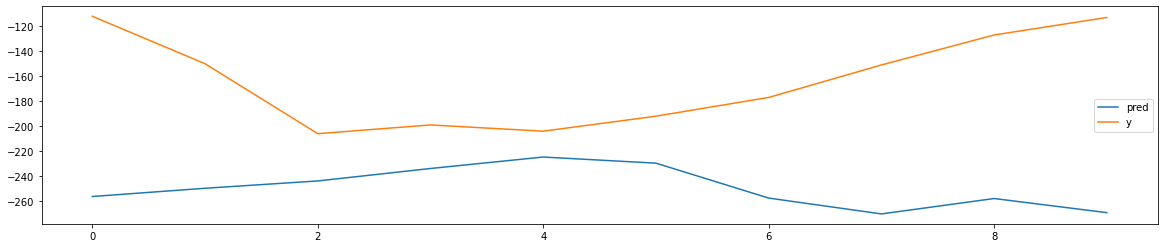

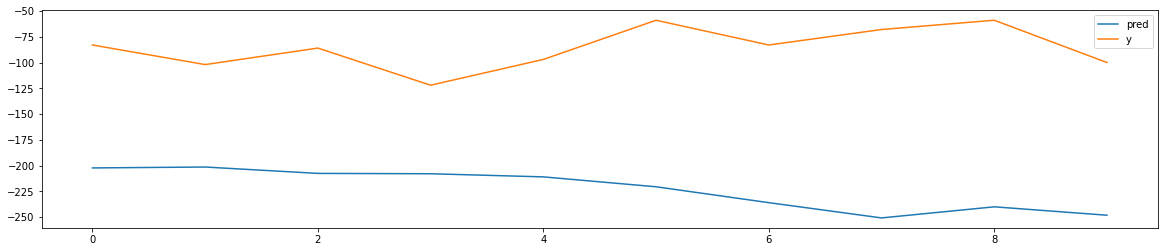

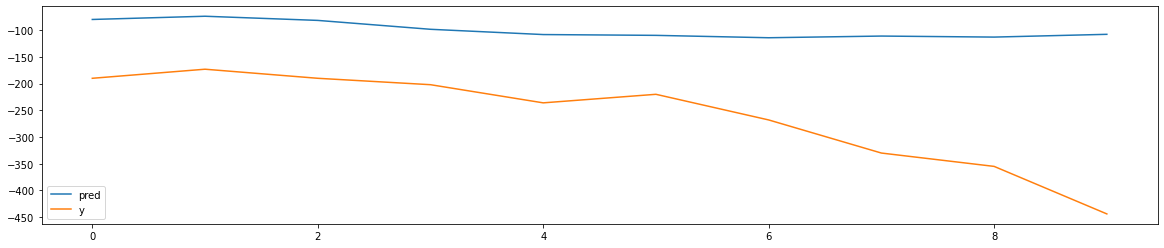

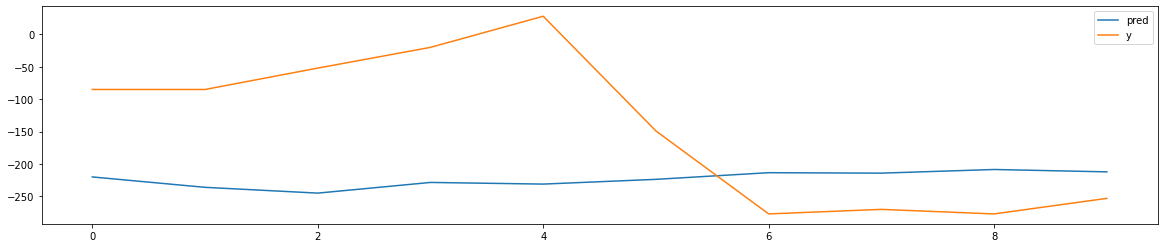

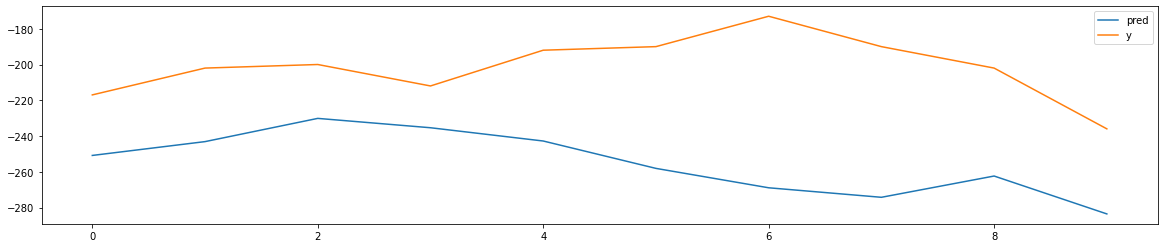

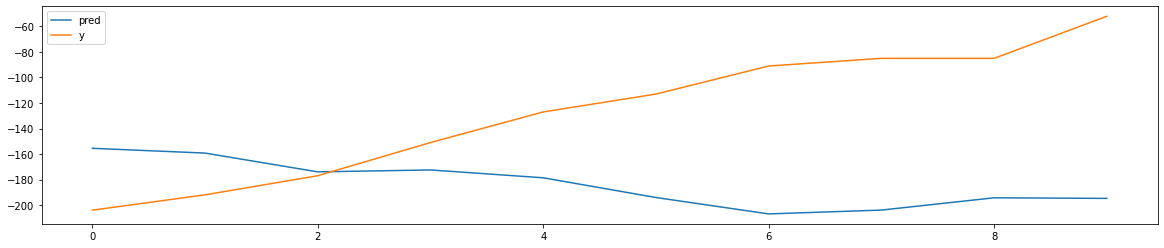

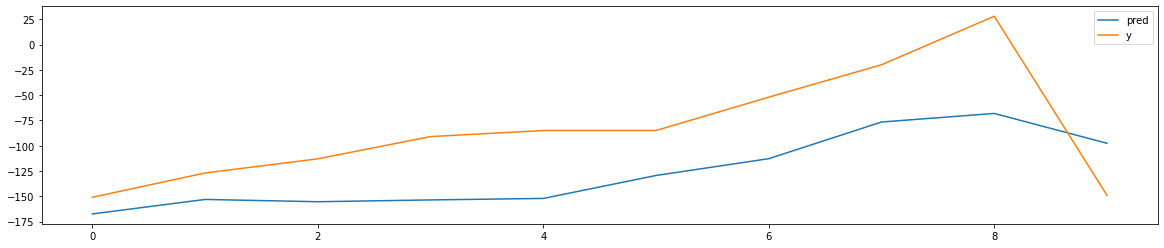

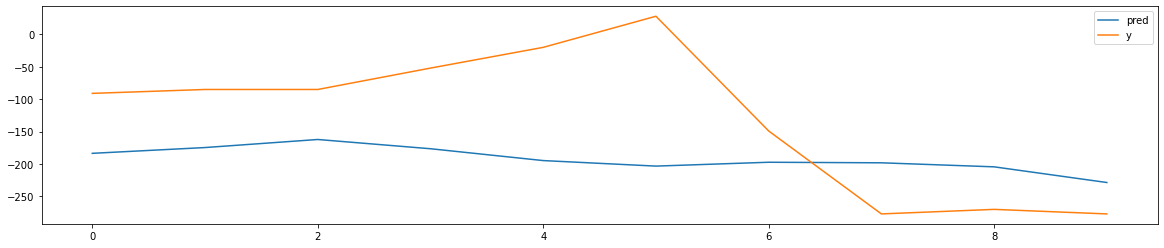

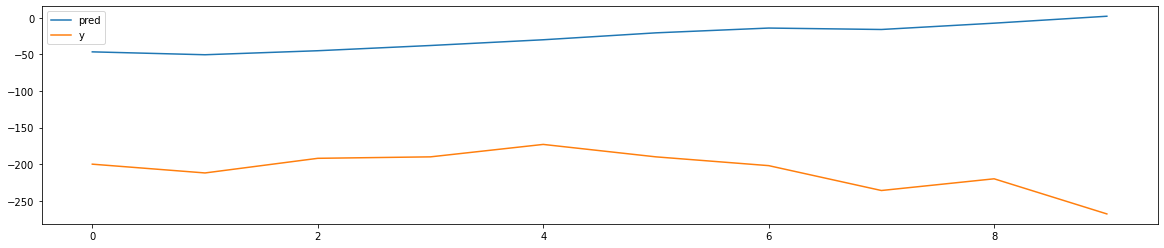

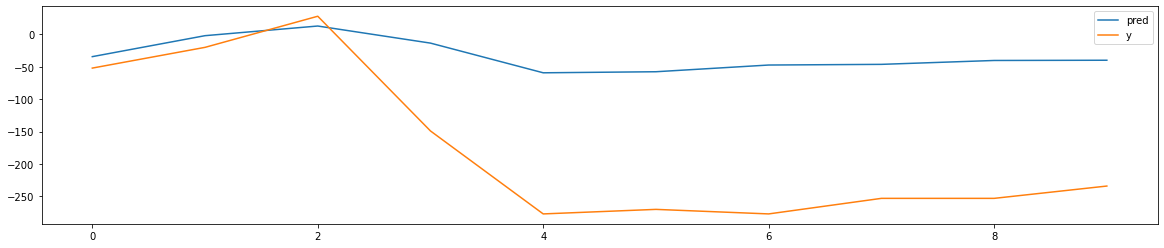

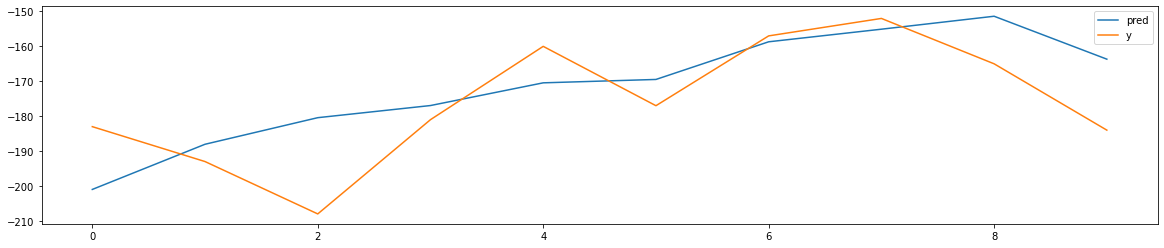

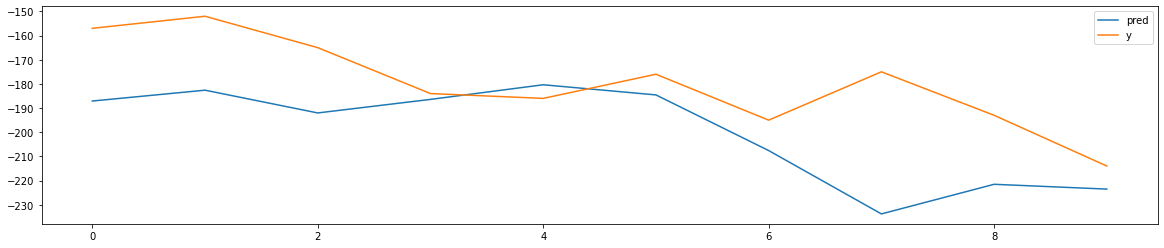

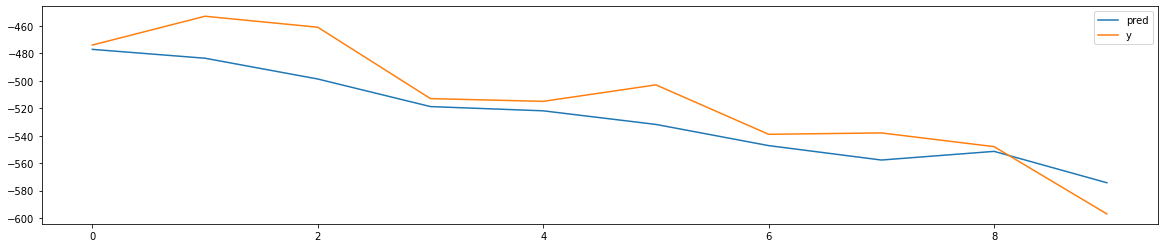

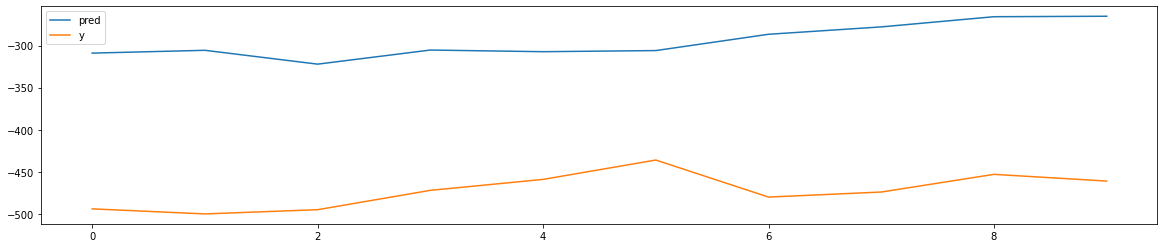

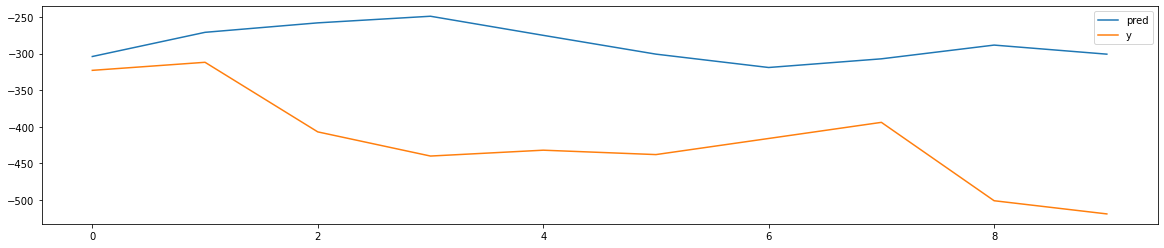

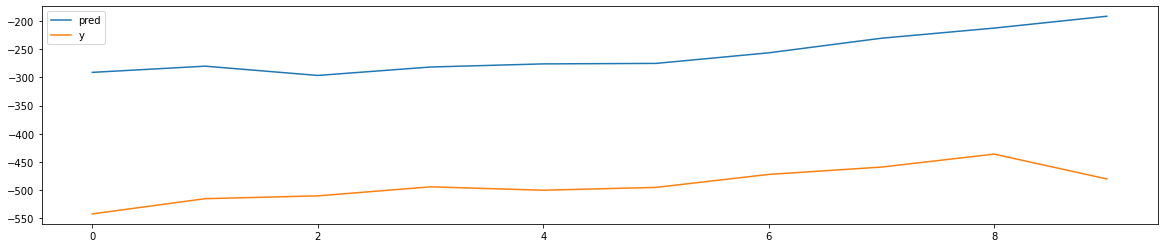

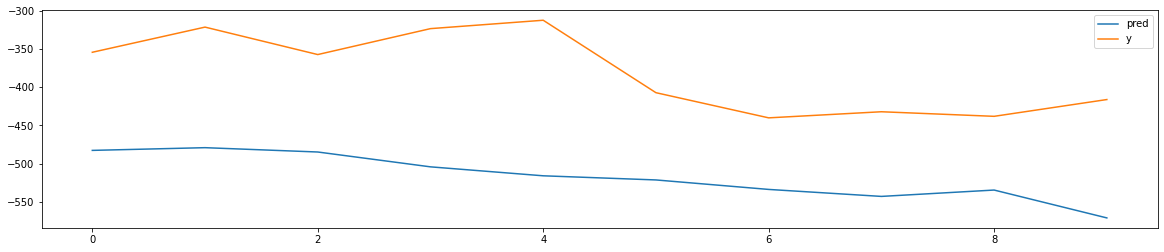

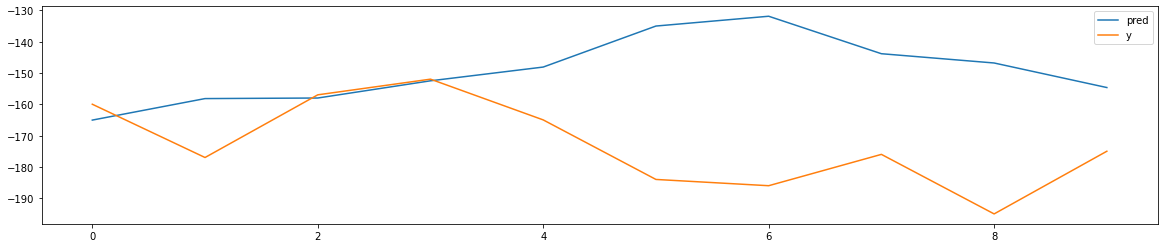

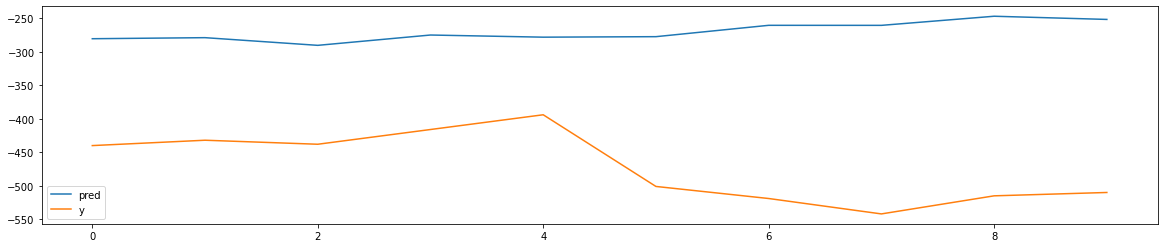

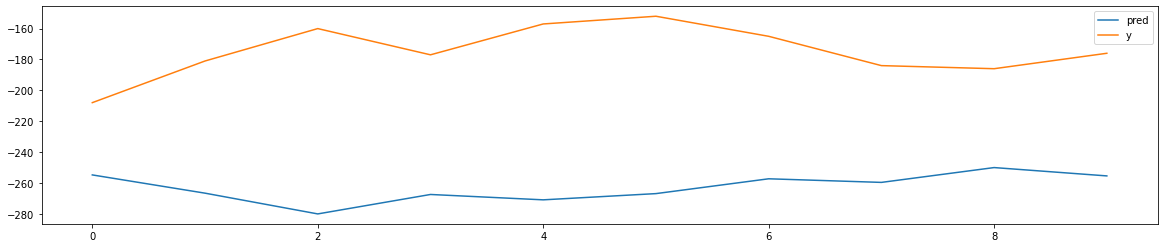

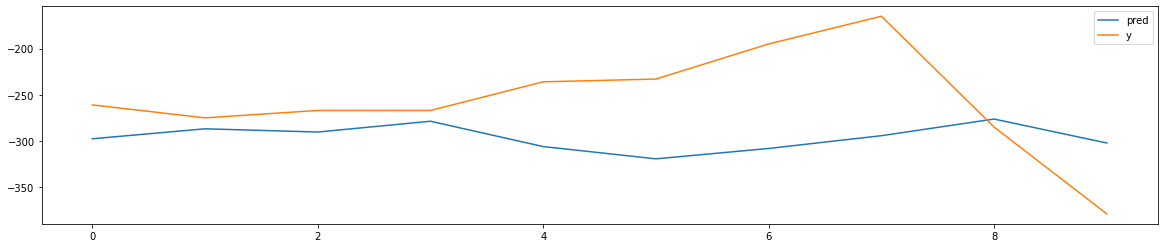

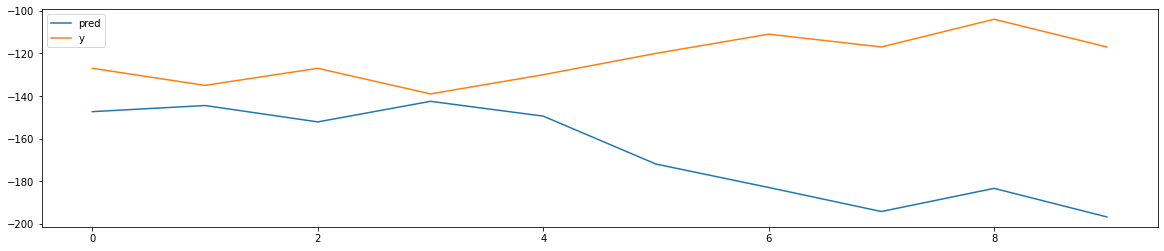

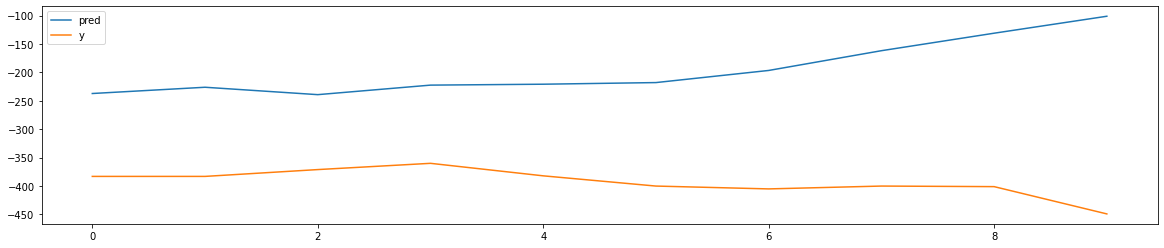

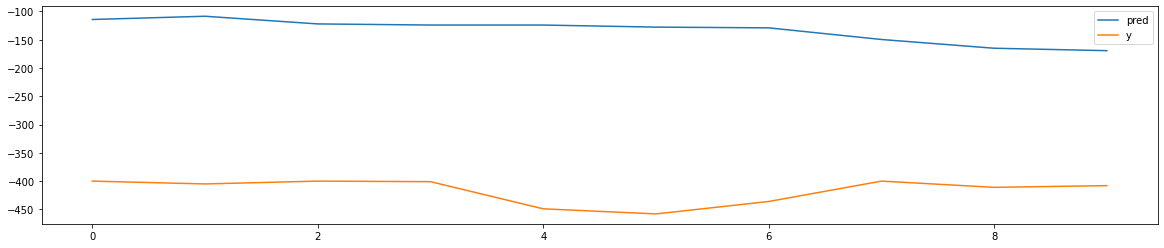

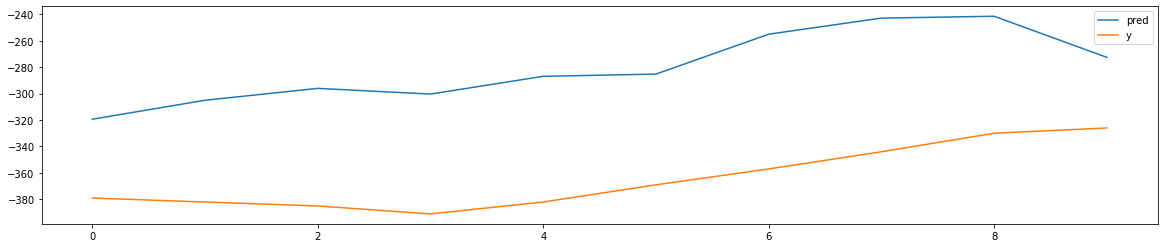

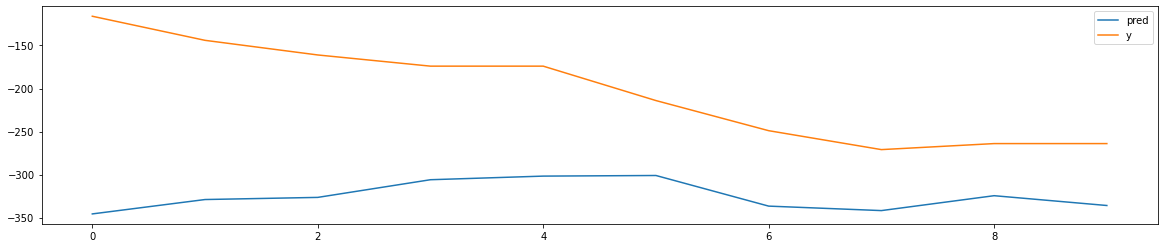

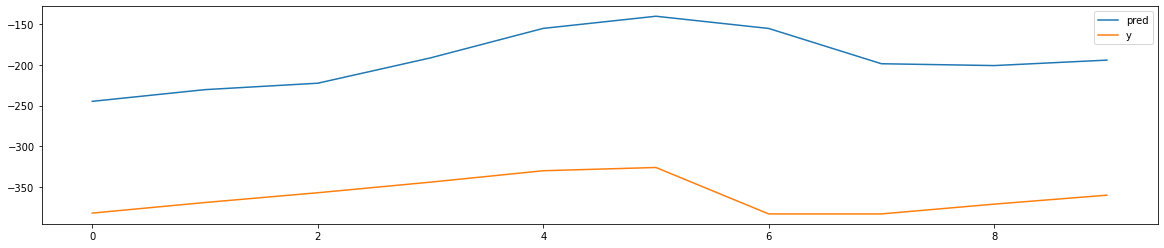

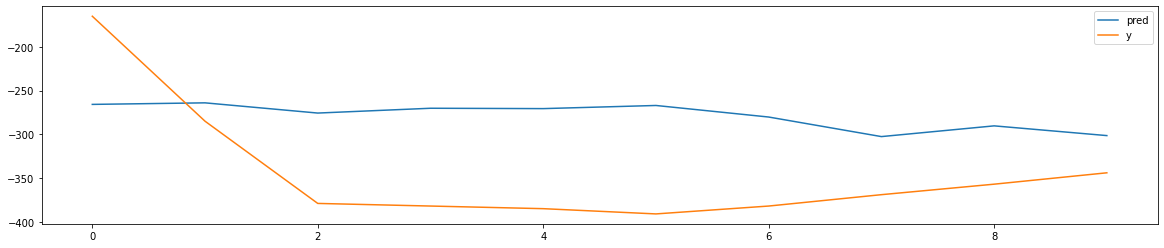

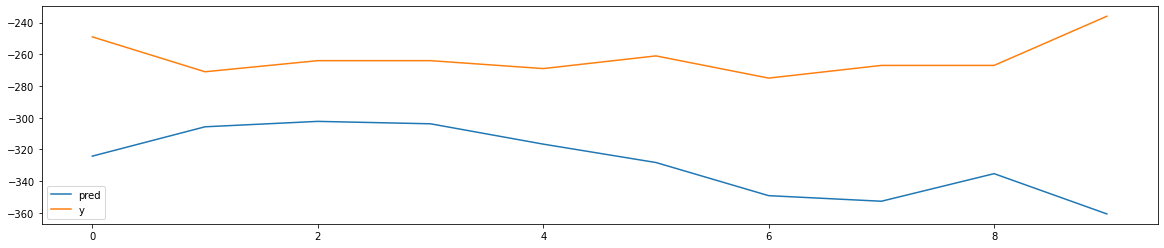

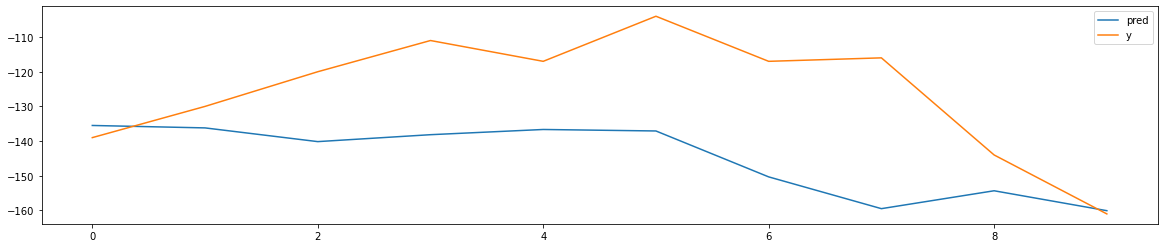

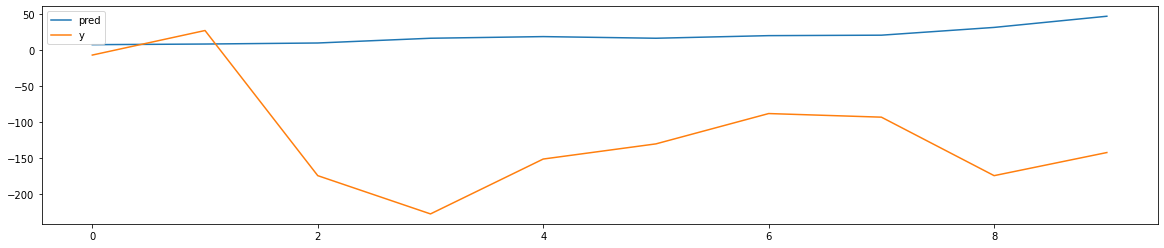

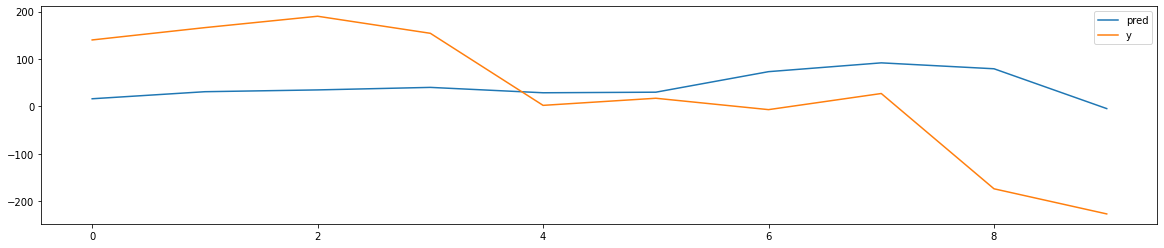

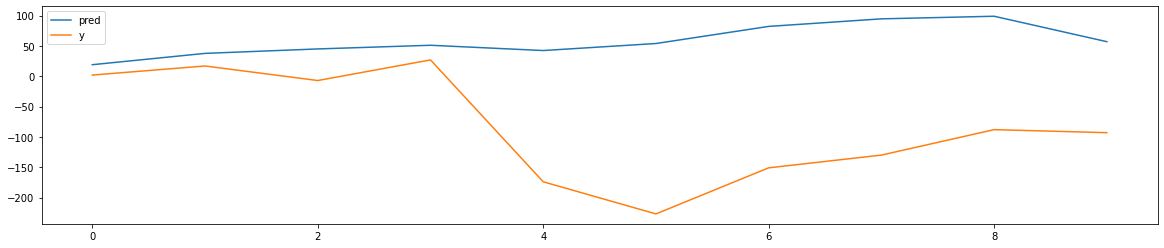

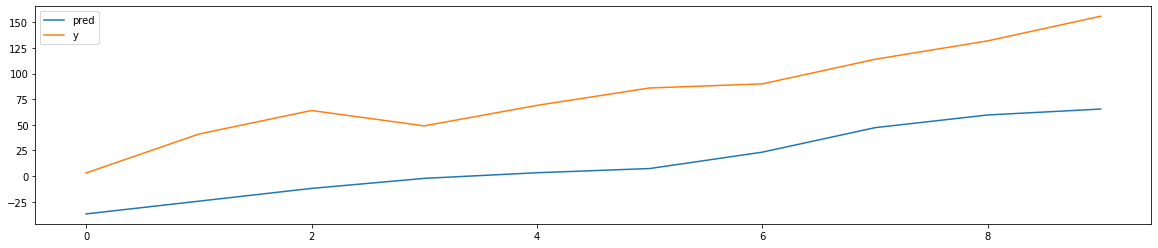

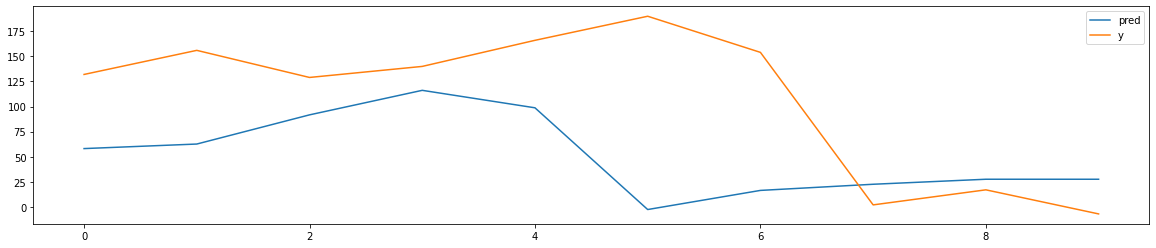

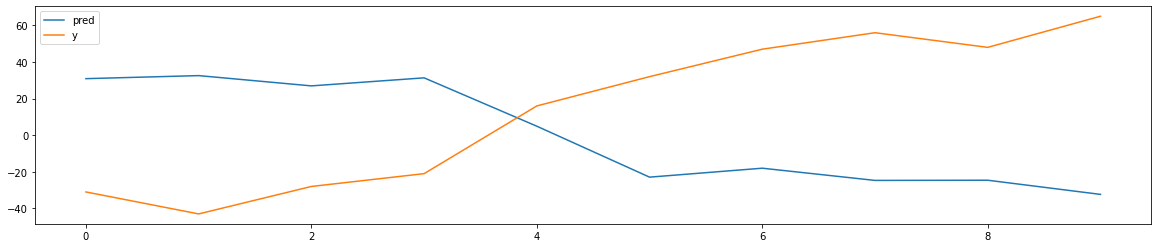

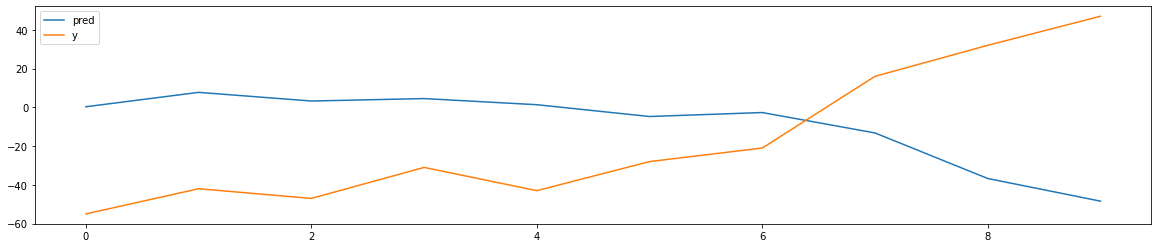

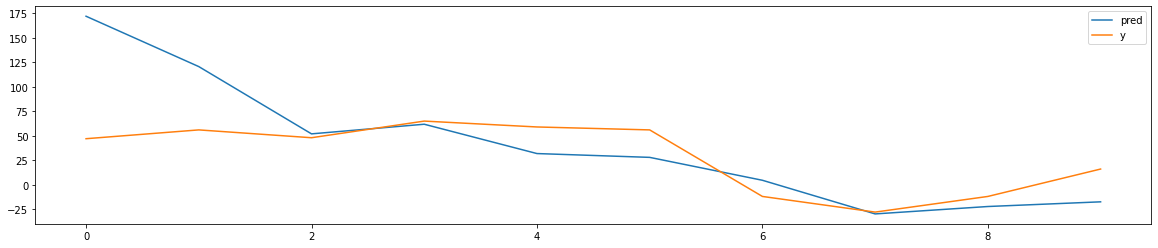

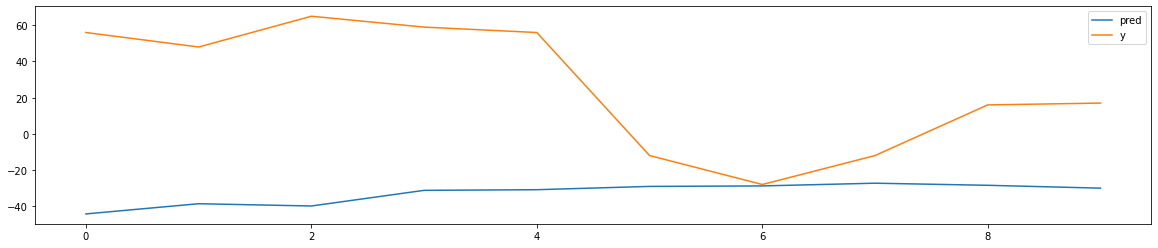

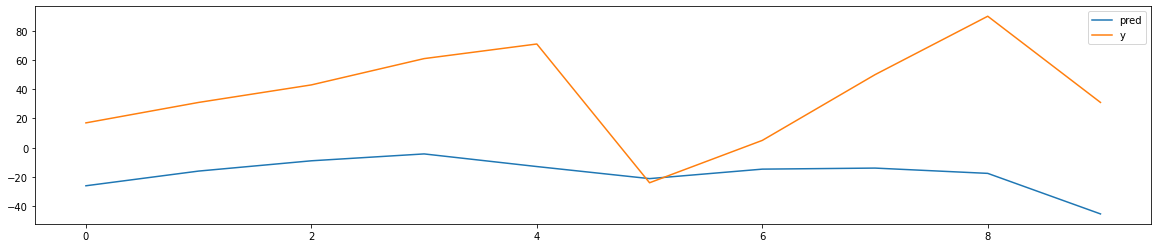

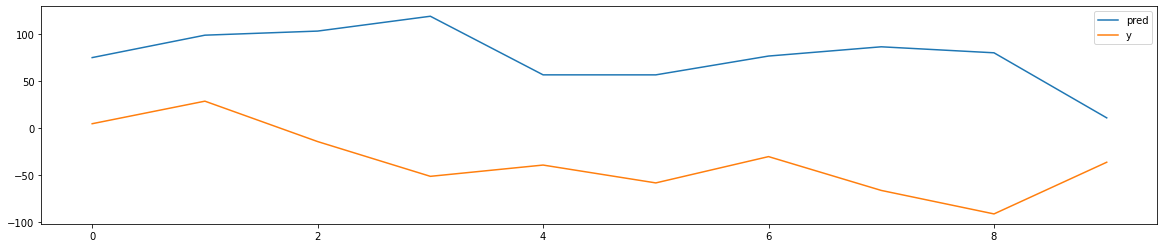

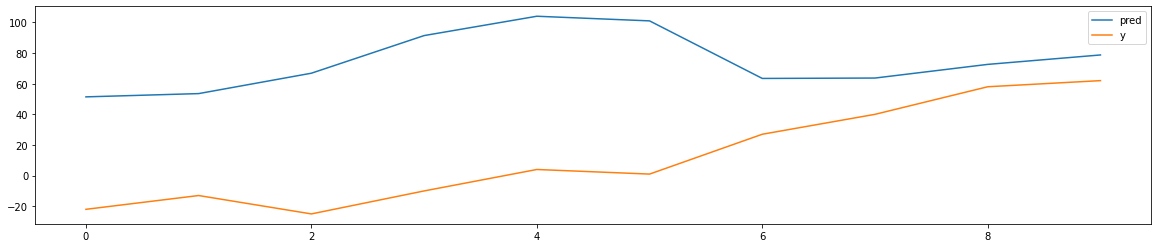

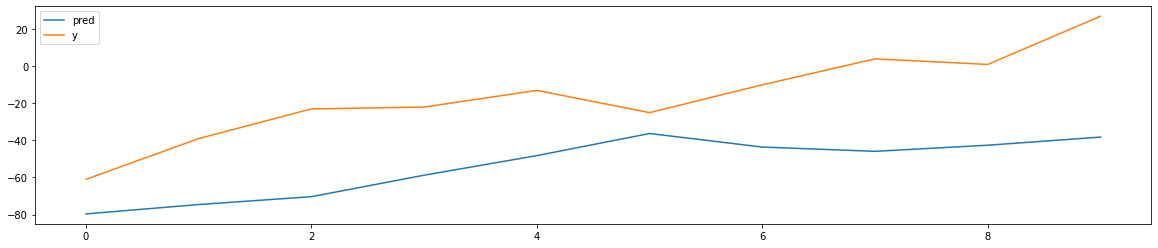

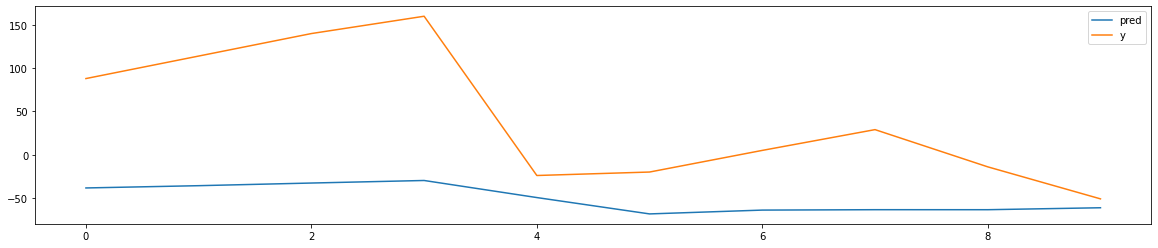

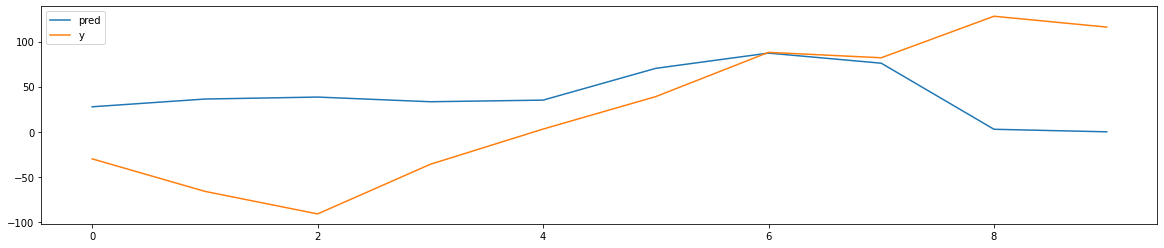

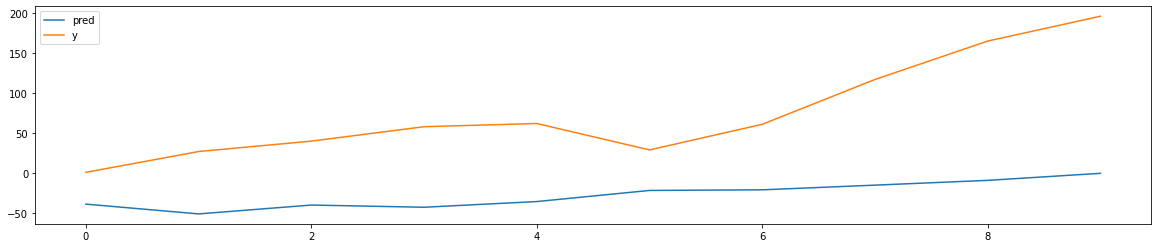

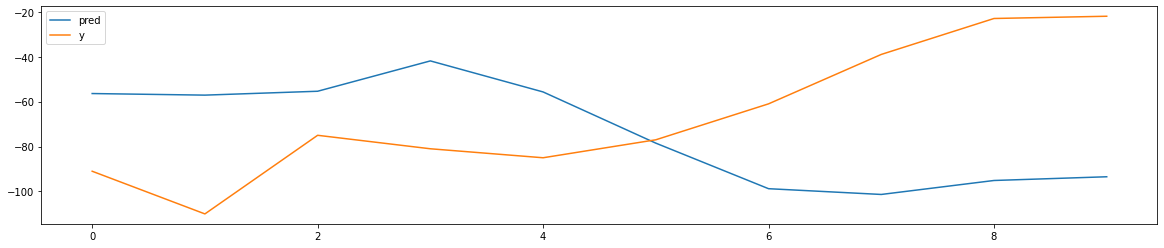

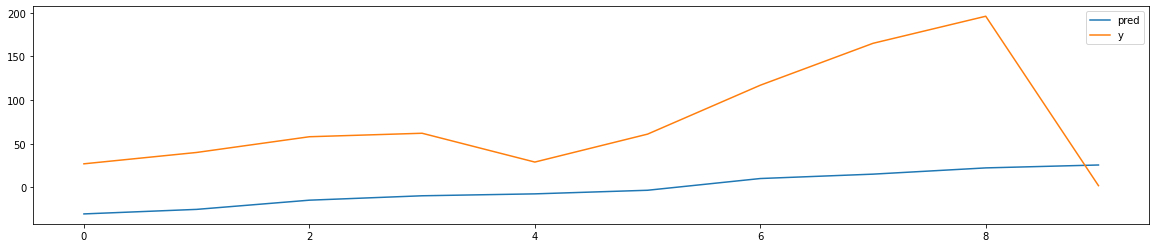

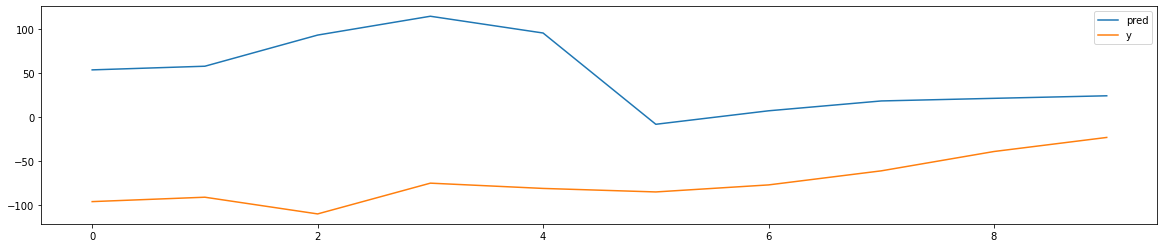

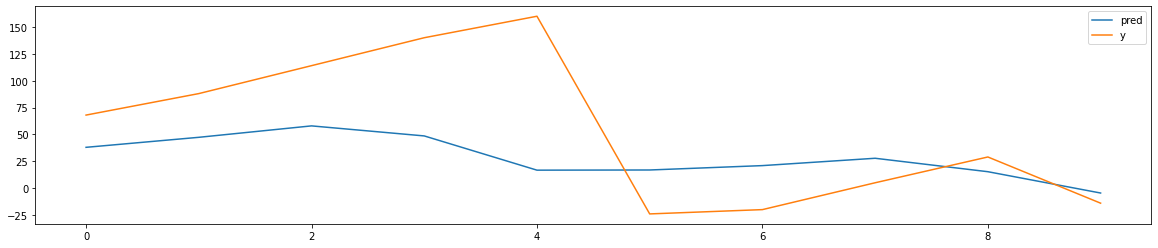

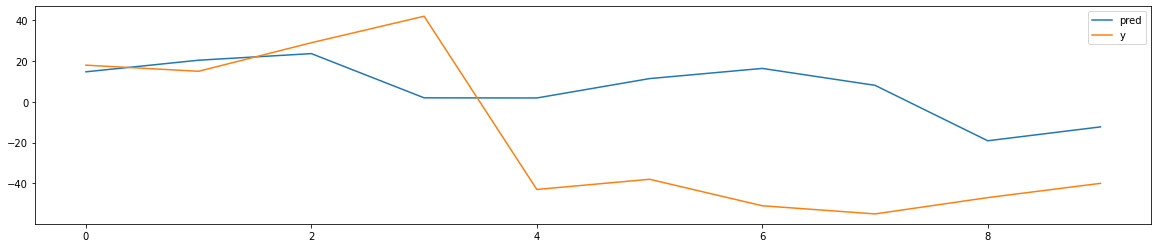

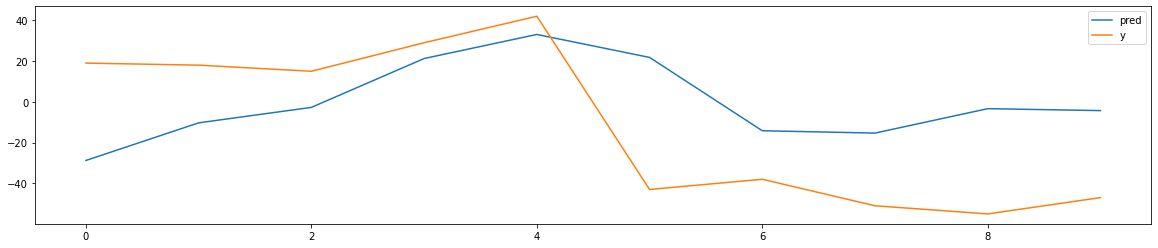

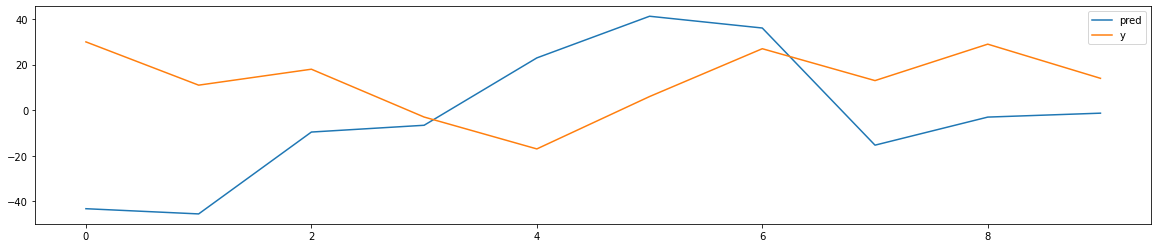

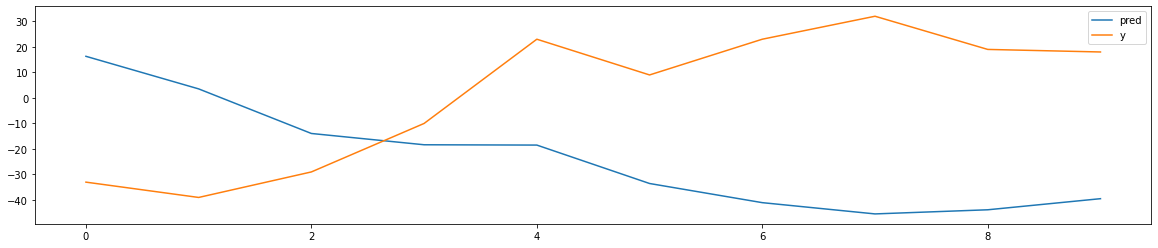

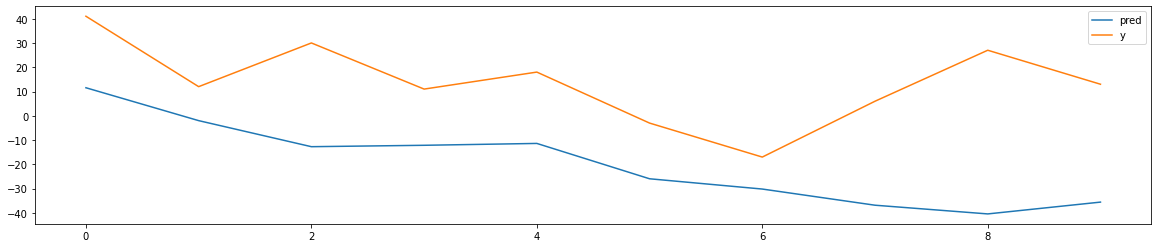

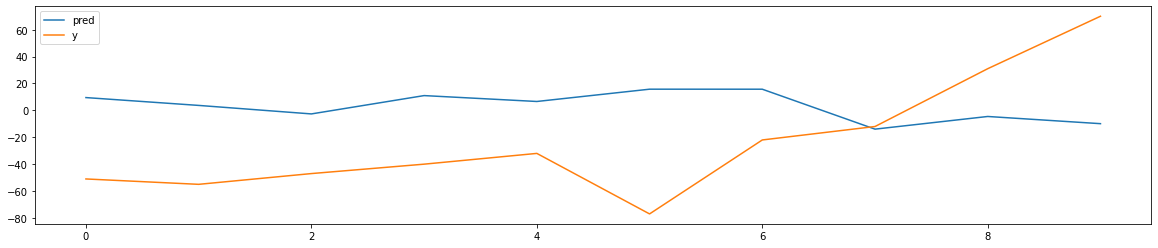

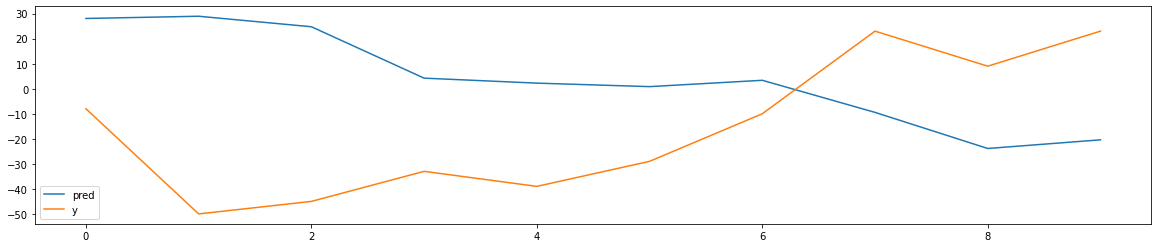

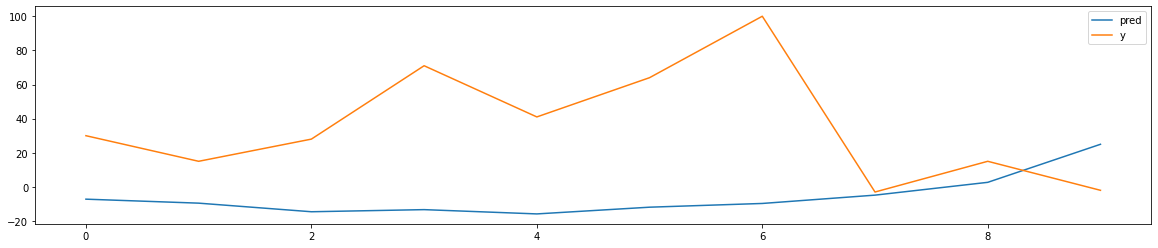

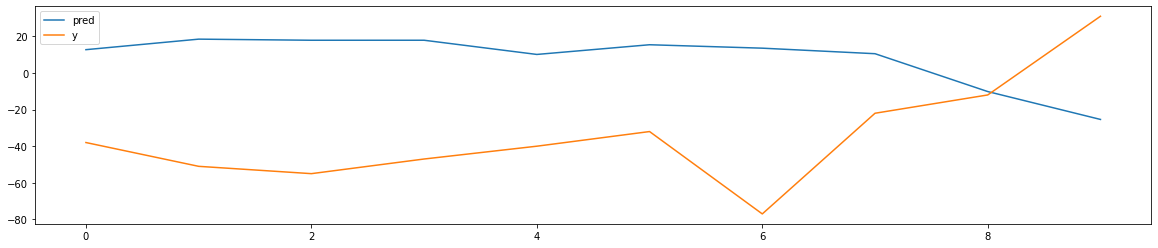

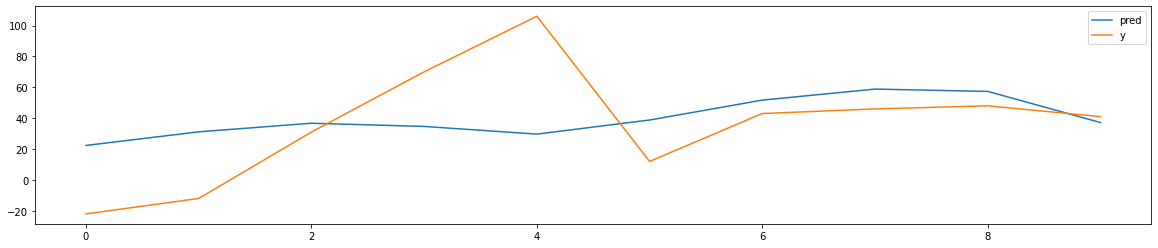

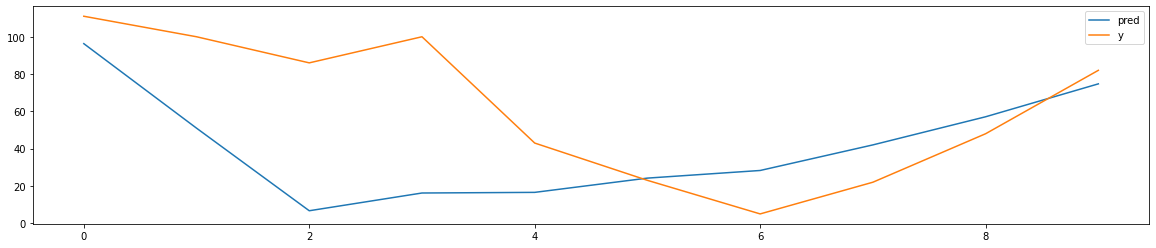

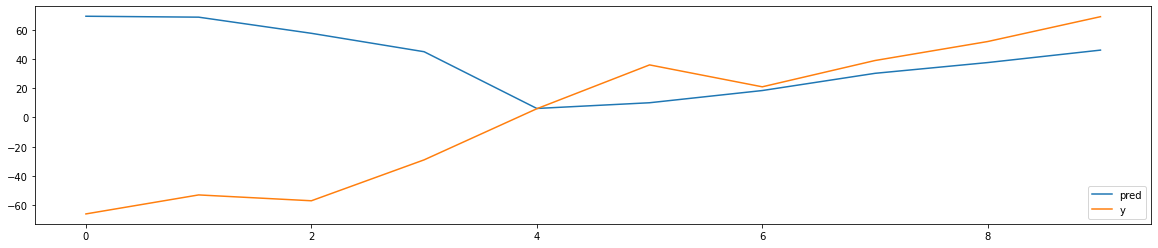

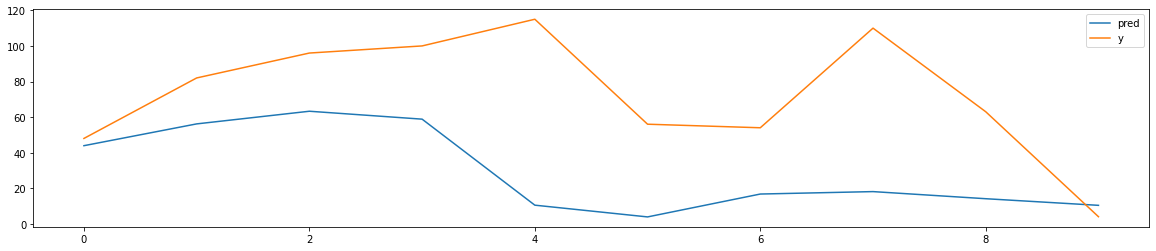

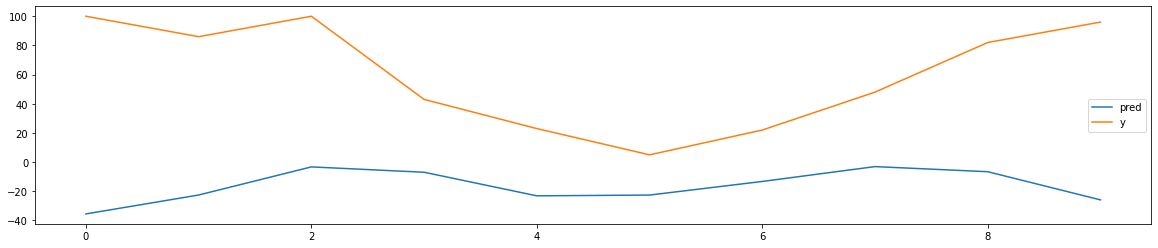

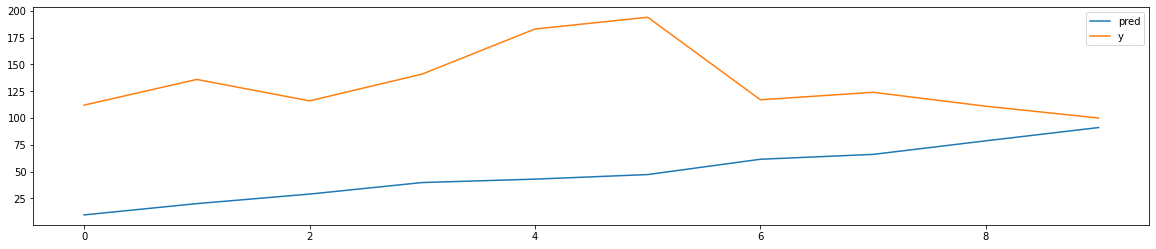

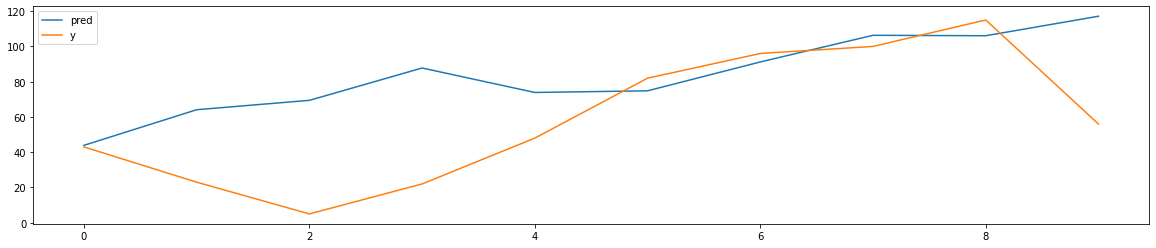

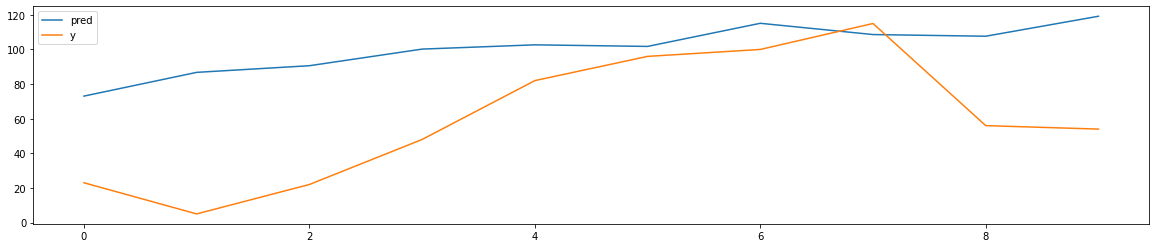

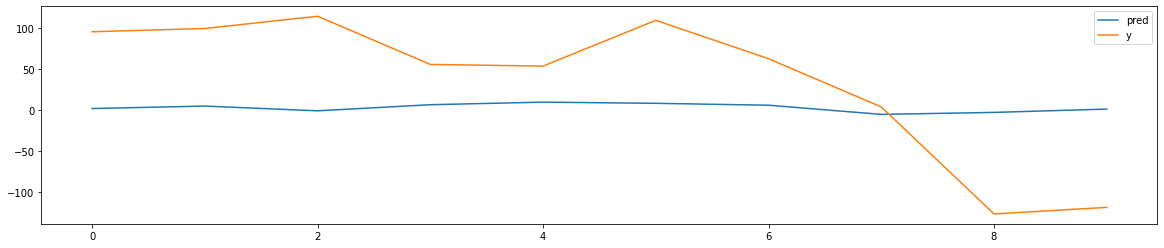

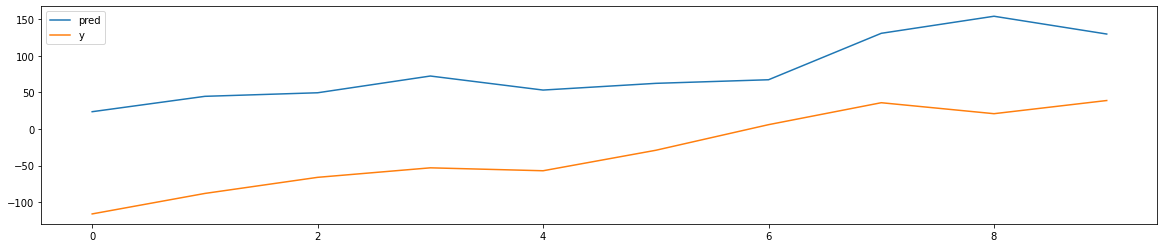

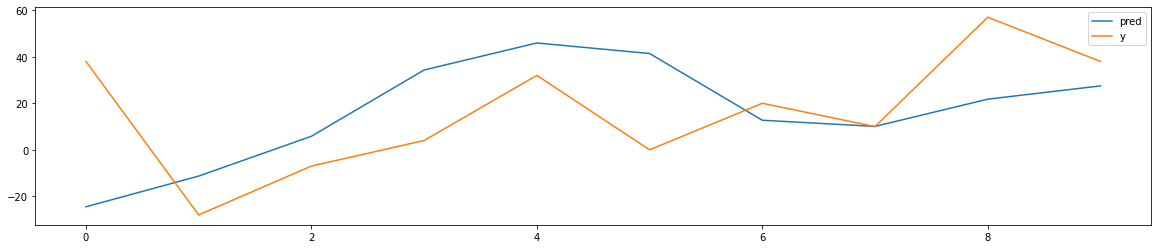

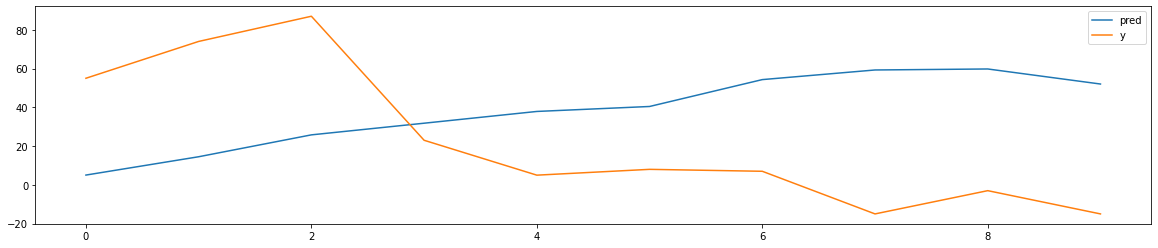

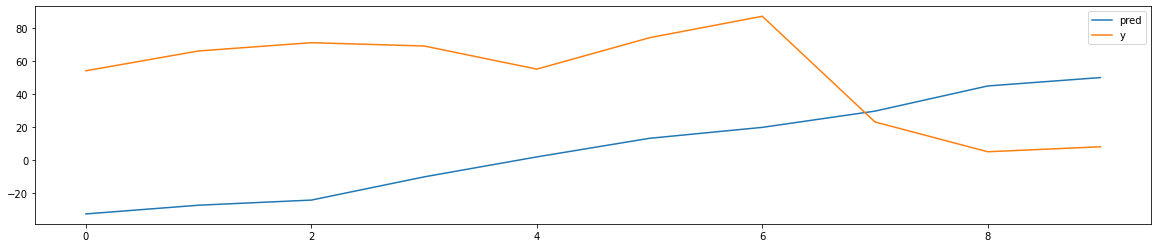

In [16]:
np.set_printoptions(threshold=sys.maxsize)


for i, (pred, y) in enumerate(zip(preds, test_dataset.unbatch().as_numpy_iterator())):
    if i < 100:
        x, y = y
        assert pred.shape[0] == y.shape[0]
        x = list(range(out_length))

        plt.rcParams["figure.figsize"] = [20, 4]
        plt.plot(x, pred, label="pred")
        plt.plot(x, y, label="y")
        plt.legend()
        plt.show()

allDone()